# Tìm hiểu về các mạng MobileNet và implement from scrach cùng với Pytorch V2

## 1. Giới thiệu về MobileNet

- Mạng này thường được sử dụng cho những thiết bị di động và thiết bị nhúng (hệ thống camera, ...)

- Cơ chế chính của MobileNet đó là sử dụng "depth-wise separable" convolutions để tạo nên 1 mạng neuron gọn nhẹ. Chi tiết hơn về cơ chế này xem paper gốc tại [đây](https://arxiv.org/abs/1610.02357)

- Trong bài báo gốc của MobileNet, tác giả giới thiệu 2 hyper-parameters: trade-off giữa latency (độ trễ) và accuracy (độ chính xác). Nó cho phép tùy chỉnh model để phù hợp với ứng dụng và điều kiện cho từng bài toán cụ thể






## 2. So sánh độ phức tạp tính toán giữa phép tính tích chập truyền thống và depth-wise separable convolution (tích chập có thể tách theo chiều sâu)

Dataset của chúng ta, chẳng hạn sẽ là rất nhiều bức ảnh RGB (3 channels) với size 10 x 10.

`->` Data point: `torch.Tensor` với kích thước `[3,10,10]`

Ta sẽ xét phép tính tích chập cho một `torch.Tensor` với 1 kernel size 3 x 3 và depth là 3 tương ứng

`->` Kernel: `torch.Tensor' với kích thước `[3,3,3]`

**Tổng quát hóa**

$$\text{Input Size}: D_F \times D_F \times M$$

Với tích chập thông thường:

$$\text{Kernel Size}: D_K \times D_K \times M$$

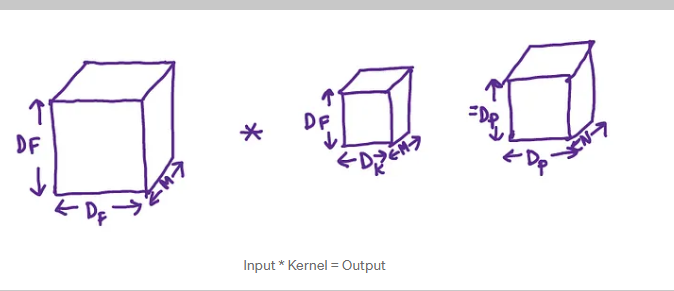

Số phép nhân cần thực hiện khi với mỗi iteration là:

$$D_K \times D_K \times M$$

Kernel sẽ trượt ngang và trượt dọc $D_P$ và $D_P$ lần (kích thước của output lúc này bằng với kích thước của input nếu ta chọn `padding = ` và `stride = 1`, tức là $D_F = D_P$). Do đó số phép nhân cần thực hiện trên mỗi filter là:

$$D_K \times D_K \times M \times D_P \times D_P$$

Depth mong muốn của output sẽ là N, do đó ta sẽ tích chập trên N filters. Số lượng phép nhân cần thực hiện sẽ là:

$$N \times D_K \times D_K \times M \times D_P \times D_P$$

In [ ]:
# Import library
import torch
import torch.nn as nn
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
def normal_Conv(input_shape, kernel_shape, out_channels, padding=0, stride=1):
    # Extract input dimensions
    input_channels, input_height, input_width  = input_shape

    # Extract kernel dimensions
    input_channels, kernel_height, kernel_width = kernel_shape

    # Calculate the output dimensions
    output_height = (input_height + 2 * padding - kernel_height) // stride + 1
    output_width = (input_width + 2 * padding - kernel_width) // stride + 1

    # Calculate the number of multiplications
    multiplications_per_output = kernel_height * kernel_width * input_channels
    total_multiplications = multiplications_per_output * out_channels * output_height * output_width

    return total_multiplications


In [ ]:
# Với input shape là (3,10,10), padding 1 và stride 1, out_channels = 64 thì số phép nhân cần thực hiện là:

input_shape = (3,10,10)
kernel_shape = (3,3,3)
out_channels = 64
padding = 1
stride = 1

normal_Conv(input_shape, kernel_shape, out_channels, padding, stride)

172800

Đối với **Depth-wise separable convolution**, nó thực hiện 2 quá trình:

- *Depth-wise convolution*: Tích chập theo chiều sâu

- *Point-wise convolution*: Tích chập theo điểm

Đối với ***Depth-wise convolution***:

Phép tích chập được thực hiện riêng trên từng channel với kernel size: $D_K \times D_K \times 1$


Số phép nhân cần thực hiện cho mỗi channel là:

$$D_K \times D_K \times D_P \times D_P$$

Sau đó, ta sẽ stack $M$ channel đó với nhau.

Số lượng phép nhân cần:

$$D_K \times D_K \times D_P \times D_P \times M$$ (vẫn giống số lượng phép nhân cần để thực hiện tích chập thông thường trên mỗi filter)

Bước tiếp theo, ta cần 1 cơ chế để có thể cho ra số lượng `output_channels` yêu cầu, và đó là:
**point-wise convolution**


Đối với ***Point-wise convolution***:

Kernel size: $1 \times 1 \times M$

Ta sẽ sử dụng N (`output_channels`) filters để cho ra được số lượng output channels mong muốn

Số phép nhân cần:

$$N \times D_P \times D_P \times M$$



Do đó, tổng chi phí cần sẽ là:

$$ = D_P^2 \times D_K^2 \times M + N \times D_P^2 \times M \\= D_P^2 \times M (D_K^2 + N)$$

In [ ]:
def depthwise_separable_Conv(input_shape, output_channels, depthwise_kernel_shape,
                                             depthwise_padding=1, depthwise_stride=1, pointwise_padding=0, pointwise_stride=1):
    # Extract input dimensions
    input_channels, input_height, input_width = input_shape

    # Extract the depth_wize kernel shape
    _, depthwise_kernel_height, depthwise_kernel_width = depthwise_kernel_shape

    # Calculate the number of multiplications for depth-wise convolution
    depthwise_multiplications = depthwise_kernel_height * depthwise_kernel_width * input_channels * input_height * input_width

    # Calculate the number of multiplications for point-wise convolution
    pointwise_multiplications = output_channels * input_height * input_width * input_channels

    # Total number of multiplications for depth-wise separable convolution
    total_multiplications = depthwise_multiplications + pointwise_multiplications

    return total_multiplications


In [ ]:
depthwise_separable_Conv(
    input_shape=input_shape,
    output_channels = out_channels,
    depthwise_kernel_shape = (1,3,3)
)

![image.png](data:image/png;base64,⁶/6tnZ27tA5JH3/ry8/aBvZ3q6q6urq6t1ehxCIIYYYoghhhhi+JcQF/6NIYYYYoghhhj+BcQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BMQa0hhiiCGGGGI4BDiECF//1yPEf5Xx2/2EXz39lSTC9BzWj42KVH6Hvk3Pjh+5r8rngREdyqSk8W0a9PDwj/onBvlHAyfwpwqvB4ZF+be5J0LhEDbN8O/BuP81vd/LZ5UYv5J/GLa/kiMPoXggGKYdrzLQ/GsY+lv5/3W6JqWAubSgHo44E16jagybGzu7B4dF/9f5rYL/sPx+L3QF/j38VwWlG746CKQKB1UEf/DYfw3/vxv/YPpoowq/VTn+ndwz/d/hoGr6EbtxIMpKK4pedFy9jshAK4E6GosgnSLe9kuuFO/gtsRK/3fldwj687u0/2b4b+M3hiho4UV0/aBK/w9AdEUMX6sRihgi9YsI4zeqaTSdMOwKEKsIMfxjEaXvlTRd/SPPYjXgUBCT3n8TbMUPK7/+mAKM8vtHwu4lV8l7JMt6EacNaOiACh3xsyNFIlqI9q7yKIYY/gugGh7Wcq0r0aPRqo79optZgHUsb7oj/HXi/DoNIZ/CWHpx/DfCCddvHVZubL802DnLZw/nTKPOPX4o/nWwLbxsF1IIt4xxPBfDbsRpTMLdtRva+XO6mRWwNZ4faY/vI6eZv+kkR4vQgFdki 77+AKC4V+/P0jnD1/74fP5jJJEu4PBVpt/BOwGQLPrZ+UI8IKZ8/q9CPJSxWC7fxwieWfm+BsKWrphwS5lB/9WdhUR6RxRzsD6laA1mv3H6EkM/3Co3to6HK7s+hOlxEG1DaYB1XpC5wjQj3bCp/F0BMpfCRq/X+3bsEnH8Ifwt7Ibqenp5teZlIS4BGusFc9fVQinMx7x8ZZfnCMOiYmJ5vp/BVXU3ILfx/pgaXwSZfa/AFFBhLU2TmgACOMXwcEtQGUZhsMpLeqXQ3jPAJVpxRDD3xXaSKo9tKZkPW7aAtVl9abTfqLP7wn3FzWMD6FQCRy6M0/i4XepP5vXYMDyY2SvVxvUWB34V/C3akjVkoUCVIiwjVPoSDM+3FjExcVRGUKmcdXf/2mwsvjKSrBi1iy2AwFwDA9tC/4/oEr0n1AkHYCyD0U18UG82exxObBn2ybs3J1vRuMWIheVoNqirmLjLsNpUNIsy8vHqqVLLd9/Z0Y0vQOzFwWbU3W2ZG33r+EPJftfB5WPDVteYfwzM/wr+ANu2kEftmzdjB9/HIc5M9fBU84HtAM+mtGkJF388cMbyENhyT7MnjsZQ78ZhE0b9sKpbSt1P96ZhGDIjZycLcjNZZ3SGKxM0dL9l6H26P/JJv2n8e80G38eul6VkIjdu7bh+aefQJ3UdNTJqo5zLrwI519yAY4++jCcfvLx+Oab4WScrFdpOeydnLrqZa182RXMcrY5stfXjLdd6SpVPDsOQxvLbcOiUPHP8rFh31uO8XW6hM6mFgrfW2sS9Ig8UVSKaSZjLNhh7HAKXscFcO8D9+Gc88/B5q1b2JhqDCsTkfz9BjSl34Vu4IkWcZhmBaeV6WhOq3BZ6d7e6KAlEdkWpDTVaUD7WhGdLq91K354QgIBjsQL83Px2O1Xo0PrNhg2bDSCfF7RSGpkdRUcaIoJDKEuFHlOkOaTjz+OM045A+UlZZXyY8sx2k/pWbmIguHb9qWzW+No+dl5s2mqMw+sX/s6+qoSNK6B5oc51WFDxM+CoWPoBujIJ4Povc2CpSEa3yqBCvnQ2fTU6WsL0a8uRIlLYdL5Lac8KJ2qsOlXRZi+cmJQJcyB6Gk6Ed4PBKVpBFD5ud5FSB2Il2hE5VmhOljplRCNbztStv/ZsOWhf+2V+GjbEQlJu2duwvxE/KPpG2dTtGI7OcgY9d23GPzNMBR5/TjngnNYF8bAz4Gl6kDIX8pwQSxZtAYPPvAUO5sOeDzlOKJnT4wcNtvkL2/nLrz94jM4rH0rjP5hHMPTO+gz8tYkK6yKXWvDulXBZRSi/chjtKyqyPIfB474/kYI0nnpSkR8+XLxkcdJy9SasnbndimSUgkFN8kTD14paUk15aMPRpsYEQQDIvyvJJSCm85Pj0CwnFcBCYnHeqjw0ZXxj58upJF46fFK0G9dG3iVihXDRUoeOhtBX0jcZaSnDxmlvIxxg2HaCr+mWS6BQB5/3eIKekgjJMWhUvKmfBAh/eNhdFIPeYW9QObPIlkW8khRsEwDiMtXQr9wHI3k84ovUMJ4ZbJv7xZZsnSeiaNZinAQvvAGNJ5JKAKO5PUv+fVLyMtYPsrG69JM0Zt5NE4J2NTC8QPh3yB/yV/Q76bMSEPForJnzkJG4sFIUBuBgCVLg/CzUm/VQOHfMJSGoc1fj6FvcRSIsEUZ75onLdIhz7w8SArpVcawLPEoWsqNagJBfoVaJMFiymy15OVRNmEWivblyMIZc1VhTCJKwxeIYojpB4Ne5pCyD4bp0c9VpnrKcKX0Y348vHSH+fO4yk3YoBLUwglHM9Aw4XC23gS8AcOipzyc6aowcfSP8sW8B6gfYRoRKAMqqyDzycxsXrpVSrOpPR6f0d8y8l/K+uAzdcJl9Eh10GIwDDfvw2Xjd/mMKvjCBUqt4d9won6/lBbn8oLPqJOWH++oSkzG+tVoWseoMwtn/mLiGGfnjz8V9SZELpQO78PpufysV+pjk2fWtJ6YMjZh1ZFHTykDka7NR5i8K1DO+BqWZePxSBkLR6u9ws8w5S4+5UWQ4ehDFzL1wx9dlxWaJsOV81k4BQuaTjgtj5s8kBd3iHUzoIXNB1qgLA+lHCVh8kue+FhTMXoWvtew+o+1yqqn5YzvYyhPBT8VJorltH+L9GrZWMbOmCPZ9Jm5YJns2Z1r1RtTCNtJc4/07NFbfhwzy8Tx+wpl8thZsnLeNosB8hjaNUfa1YS8MOA9Meqn/LMAp85ZqTXGBLMY9NBWaE3TwtX6Q70y+danmkPeG9tnFaGJp9EIrQd6H+3+SdCuzd8M2qvxm5FCUiCIJI4hklLSkIwUDg69uP/Om5CeWQM/jp0C0SGIPzx28wYR1CUz5khXTyXgQzAYD38ohXfx7BBVLK4bl8CAusgeIBG9TUrkaFj7XtaGJiTotIiuLAh9HIYPG3HxDiSnJQFljEsyqWmJEL/SCyHoLjG/mma8Q3nzIT4uCe5QAMmOZPLGcB5Nl3SDCfBwKKW9uwR2AXXwy/9IcCQhKS6NV0GkOJPo50Ao4CFrpOtMhDPeSepxqFe/Lrp3O5wpAC5mPo6cirfMIsKsJOovodOetpisNZMQAm4vHInMI3upjkTKSCryZ42YNTLzZ4RM6FS6ZoveNMxm5iDBmQBHZEGF11a3GXHh3mcQXma1iCPJivVsGgZDJjXRgWA5OdcoWm4ax8sbH3njpfb8HeEii2ea6qccxWt4vTE8Ura8D1Jwmr0kDauKoyNX+vt9JYwT5l+HrJTPni3rccddD6KoNAg/RaoRs2rWwBEn9NIswBf0mOhOTdSGg/pDvhL5Lz5O88KIHOmkpGVwIMfQacmG4UReOsPREpNTeJ0MT6CcnupBlgzfdMqKpk3QbJpfXa5QlUtKoE4wQPixFd6OExcmrrqgMlV/wucNwVNOITrJQID0/EUo27EO117ZH+WlASSxnFV/U8lEalwq+UpA0OdlcM2L0mTCOm9udqgxIZaNLr/HkSHVyXgK2XoSB7fqoN6Qz/TM6rxgpuyNKnqp1Y0smF/l0+vGsC8G47OPBsHnDjAZDcs0OOrxeEqZJSuuzqiUleUjGKL+sn5pfU6iTMq95YYtFZNum9BqS40lC1riKpSgtb7tZ+LMf4AjLn2kVBPjU/mr+WP9pVKmJcdBZzv1me5hTCaxeNa7uPgEliPjB5Qv5tKWs4L2IcB8BB0+ioVlbDzJkCpPOCuaYFJyGn2dDJNBeWmBqzBIJ448MVxIxUsvC/EmT2ybybJqG2HoMLjK1oCRlA1VKP3V7FIGQdLQtU+92bV+DYry8uFMSTdafnjPrqhVO5NVVQXAwCEXVi1agO1bc9C0aWeGSGK6Dpx05rHo3L0Z7xUBFp/HHOriTMpQdunlwehBX+Dd9z6h/K3kPd5ixqXNMOwqs7xgBXUmUvdpgVibmf8AnLQLCi1CjWdG8UZQtvtnIv4ZInz9N4BqUVhjeDnm82HYlZ2HC2+/ASmZ8UgOFmPz6q34ZPAUHNbjWJx96gko2bcbw95/F1PGT8fWvBCatWqBRN8+/DjiG0z4eQ0aNO2GapksVGNsA/xlybpKkLtzCz5673WM/G4EcnKBdh3bszEqxNixwzHzx58xf+ZsONMdWLdpA74aOhpbt+5Ajy5NUV64D99+Pwn79+Rh1+bl+OKdgVi5eC86dezOBp/VNjkBy35ZiFmTJqNOjQy8+sZrKGXa7Vq0hafEha8GfoAfBn2OlUtWoNlhxyExJQnJcUEU5+zCwE8GY8XGPZi5YDUaN2iG9LiAaURmT56NH3+YgBVr1mDDpo1o1rw5jWMydq9ej6FDhqJW29aonZYFT85mjB81Ejuyy5CbX4TP33sNi+bPQ/vD+yA9mfkOaCMbxJoly/H1oMH4ZdxE5Ozaj4ykOvCxgUvLYqVwUPCR/pWuVyfgh5E/4Pvvv8ecmVOQmZGBhk1asOIoPQ+K9u/B4O+G4/uRozF/xmw0bdQMKTWrg4MauHI2YdLYkdidU478ghK8+uzDWLduKVp26obVK9Zh7BdDsWjqPHgSM9C0RV249+3E0MGDMH3VbrQ7rCONPrBo1nR8O2IUvvn2e+TvyEfjuo2RWk35pOko2YOBAweh8wln4ahjumHJzHH4dsiH2JUTRxm1xOblv+C7LwdhwcKd6NjhMJTtXIaLL7oIC1fnwCepKCktQJcOrVGwYysN/Xuo3Zoyz6qGhJAbofIiDBszDkO/HoYlU2fD7wqiUeuWNOaqPzlYOHUKfpi8BC1bdcKgNwbg28Ffo1nHU6in7FCQNd3EEUxw0w76aRzLUF6USz0aibmzlmDiiDFo2qQRqtetaTpq8Lgxdtg3WMmymjVnLnaVh9CqReOw0Q5Dp//YaZn540hMmT4Bw78fhdwcoEO71jSA7Cay8bNaPQdy187BFZddgcVrC+EWduLc+di6ZQ2+HzISyxcuQ1a1VOzdsRPffDgI82ctxr4yN5q1bIWitevx5SefYDcbo/qkq43I6O+HYfToIZg8ZSKKyuLRolUrbUPBwQjiqDOmAdYOmSeAhXOYtzGTsXTxIqxfsxwtWzfGTxMn4I5bHoDP40BBuYedlixUy3KyvS/Bt98Oph5+RX3cgLYsr5o1UmjI4zBvylymNw1p1RLxCfkZ/9NUZGbVR92GtY2BNg0pG15HuAFfNHMOZvz8MzLS4k34ceMmISOzNmo3rsenDuRt3Ighn3+IzPpZ+GzocIynXTj+6O5IZD5WzZ2Jod99izFjJyFnTyka1G2G5HRnpDNYmr0bXw7/AsNHjcD6pevRsU0bJKVpD89tGvvBAwdSx97DiuWL0bjVMSwLNqZsMfds3YAPv/gKqzduxRzag/q1a6NmrXT4ysoxbOREzFuwAquXLkdJQQGatW1hJcZ6p50V7e3GaUtb5sI48jbyhxGYPGkqG+MU6k0TJCUFMXXcKAwfPBjzlq5BSWI1rNqwHe2aNUKtrDSzUTPkK8XqhVPx8YdfYtGqHITYaZo5ewxmz5yOmeMXYtv6Xeh2VBcmyjpeugcffTQYzbv3Q69jeuKX4YNx6023wZVQE4VFAdSkXBs3qoWNu3fgvfc+xA9ffoeSnGK07trNlFccXFg2h/WB9iQ9oxZeGTCQ6TvRqnUTtRLsqzMv1HMOFcyv3eE2NuSfgvDI9G8CHfDrtEg+L/PluiNPkJbx1WTemtWyIX+bzBj3kZxxZFtp2bSXrFip4QifV4Y+/ag0g1MmTthoZtmkPFsWThght949IDKjplMzZkosWCgLpkySB264npd7ZfOyJVI3o7U8fP8r4mHoEvceufzUftIyK0O2bV0nP06ZLJff8qDklPukKH+dPP/4rZKWWFtOP/FSeeT2W+WVBx6QJvGN5Nh2/WTvrv0yfOgQaVejgZzQur08ePOV0u/YTvLEE3dJTu5eueyiq2TT0nUieXvlwj79pGmr42Svzo4VZsu5x3WT1eu3SAnZfOCpj2TEyOlkt0BWz5wsF/c5z8x2FxV45Kqr+8uOXXtkwYwZcvHRR0urGtVl0fbtsjdQIh+/cpc0YOf6mGNOEZ2m+eqt56V17VS55Z4XpMBMtRXK+K/flL7H9BZXrks2zpwmLZNT5YjWfeXZRz8UnytA+dDp9JFO8ZQXyU1XXihffv6peL1eeX3A05KR4pBZSxaYiZwl5OHUo3rJ/NkLzdT4kPdek2Z1asiXw6dIEQN88tqD0jAV0uvYU+Sp59+Sj954TBpUgzzwyOPiKRO55aSzpWeNZpKfp1PYJOgql8duu1kmzJwn2Sy4AS++LuefdYHs2ZdrptKvOPVM6d2hh+zbUmBNGe2cK+05EHjm1UFSzFvxbpe+PZvKmeffLC6dgwvlyvtP3SG1sjrIjk1MsHSLfPDULZKS3kYWr6fYqQ4bVqyXs7p3l1Y102T5nnXW1F1xnlx+Yl9598OBRhTbFy2Wns3byPXX3isBynHjtG/lxPYNpEmjHnL33a/KiIHvyKndukv7zufKHjISmX42TNLDs1VOOaGjPPro40auY78cIS2q15cdOQVS5A/Is08+Jh+/OoD5L5LFs2YbfTP5saFkAiH5dMArcnyntuL17JCtO1ZKzbQWMvGHRVYYEvb5KMRyFeZyef+Ra6RWRmdZtMQjhflucVHIx7TuJJdS5ro0ESgvl+tPOlU61Wok+ZSDTvBKmVv6n326rNuyXPa58+XkMy6S99/9jA88smzpLGnZor3ce//zpk4pSwZ64c6TdXOnyRVnXG5mz8v2lcil55wleXmbZefOddK723Fy2RnXSm6uh+UclIL83XL9defJunXzxF2aKxedfK70bNtVcvZskrGjhkrbeo2lQ8OWcsdtN8mzzz8qx3TvIjVSs2T8pMXiCidsLdWUy/jhg6Rrk8ZyWLMmctetV8nzzz4gx3TrKNWSq8nIiYtk/tKtcnavY6WxE3LjzVfJWVdcKocfdxp1yiVvPPOKXHzqWVKSXyilBUVyzVmXSp/ux8vefTqhKbJt2Qa58ORTZfmq2bxzySlH9ZY+XXuIu2CLZO9eJtdcfLFsWrKU9XmjnH9iL2nZujfpMmhBvpzX50hZtWGTWhx58plXZdTwEdTPHHn96Ufk9Vc+M7P0s6Ytk7tuu0+TMrBWVFTjSlneZXLeCaezTg+kjXPLknmzpWurdvLAbXebsMW0JzOGfCwNkx0y6KcZsrwoJHlea2rYAhW1ZKmM/OR5qVfvMBk7dYPsztsnq1ctksOaHCY3XHCrZW4DTGv7z9KF9fL5V74wsX1bV8lZ3VpJnxOvli37GaTEIzMmjJEbH7hddhVly4pZM6VFjbpy211P0l765OeR70q3Rg45vEsXufWOR+TIw3vLg3c/xogkxjRMMsbpRLs1yWtN9P5z8LduSG86tp80Qoqcdsklcs4NV0nPDk2kU+068vozX0oxgxj4qTBb50vHZMgdt7xuGdBSjzx64/Uye9EG0x6YNtTM3e+lfu2Qo7sfLcO/+Uk2rFsnm9esk9N7nS6NajaXLdn7pNiTI6WbZ8rh9RLlqiuvkzMuvUXW7y0Nr3Hsl71blkrthJYy8Plh1jpQ0CuTP/pAGiJBBn7yjTHE15x8gfRo2JQ87uGdWpYN8sZ9/eXGa++UVat2yZ61y2XgywPYLWss3341U0qXr5KO6SkyYdJ8KSWva9YUy7ypc1nxdsuwN5+SXq2PlZytVHDajinT5srubGtdYsI7H0r7jBqyPDtP8lRF8+dJ1zpsqB5+R9zKiH+33HnBsXLMcZdLkS6H+fbIZb3byeUX30UDxnv3brnjzGPl2O4XCO2IsB5KKBSwKjQF98ELz8ulp54iPrM+6Je92zbJVZefK3NWzJB8V46cfGQfefyWx9gAM7yajOL5cn7f1lKtfk/Zq8vDOWulUw3Iww+/a5Z6JLhNbr3oCDn2mLONvd88dqy0i4N8/dVEU+ruQo88dOsN4irZIus2LJH0zDYyedpmJU5+8qVk3WTpVssp99/wguW3bYl0YLk/M+AbIzcp3yznHNNUTj/ndrN0Ke7tMnTAvWxIu8j2jSzB0q3y5TO3S80a3WXdTqtya8GOe/ddaZmRJEt2raEcffLVC29Lz5otJb+4jLmmIFwbZPgHz7MDVVem/TSLdDfLAxecIB3bnSw5ujjlKpTp330uiRntZM46t9E5C8x0oFh8uRvklF4dZcjQEeJlRjdMWyBNkrNkxpKVstvllrNOOdF0IBQBNoZDhvzARpE34UbDgKRefOhpufXKy3izT8qLN7MB6SxP3/OSePlM0zTBQ2yCg6vk86dvkNpZ3WTLDt4qrYBHvn3mGemQUo0dsRKzVLl69ChpDodMnLnSrHpt37lbHr3nOl5tlq8+ekGaNT3ONAxmXc7vZsfsVanFjtfwqfO1Xyfs15EuM+TfKoPfeEiOanm4FG5hYvSax07azpw14g3lSd9uveTas68Qr99neHzhySfljptukq3bNsvG9evkjaefk3qZ1WXQsGFSwg7bVaefK6ezjrrLlSuX+HbMk3ZZDjn/vFtMOZtyMznWHkChXHPqGXLmsSdImYcdLNY3985F0jYzTc475wF2Othx+XiQNE92yuRf5ps1P7UvG1fMlBppDWX6pJXGR8pLpXjFL9I2HXLLbXdJPutH316XyFfvswE0+wr8Mu2H8fLgtf3ZQG2Qt5+7Xe6+615Zu2Yj6/Nc+eClpwTJzeS74XOkZOM66Vg7Q0ZN+MXIaf2mHTJzwg/kdYtcdOLhcuetL1AWJMM0hg8fKyVl5eIJmS4cQQ4Dm+Sz5+6UDhww7KcJMVsdaOeGvP2M1EuJlzGTlpiQK1l+LVPiZPS8ZbKd91qlraZUhcSUPevll+/ek6wa7WTmilyzRu71F0vfw/rIzRfeZmhIiB3MndOlGxvSZ17+wjT8Ur5XLujaUs45504pUhHvzpfju3WRr36aLD+vWiPb1i6Si07qJ7XrdZUdO2mIvWvlljM6SceWR0kxmTB7TZiOrrXrMrFbb0lWy62iGVWD8M+BPYf3/w9rtF8JbrcbacnpeO/dd/HNp4OxYNlqvPXOu3jtuadxyTlXYX8RAyUkA43q4vrbrsawYZ9jx3Y/iovKUBoIonOn1vCRpnl7JkGngYLYu2sH9u4rxuq1ezB67FRMmjIFZ57RD489dC8yM2ohLSkL6Q3q4NlnHgV7kTjjtNPRpH56eHY/HgkJiUiOT0FifBocujwAP07q3R010gXL16zVJT6m50ST2g2QlqFrSBrTg5Xzf0FOQSlGT/4FP0ycBI/PizdfH4D2bZohvXZ9dOt6OM49/WS88MRbqFszE0cd30uXL3DKKacgN28PjuzZBaNH/Ig+J/RCzTrpZgZcdOFTHYuxYpcyIeH1s6AfafHWFJxZ/vX6zGEX6zduQrKuYSU50aBpQ8RnpCIpk1EoJ13p0PUgTXzO1Lno2a0XnHGJpCyo17AuBg/9Bj27dEBB/l7s2p2Dxk3ahHfTko+UEC44sx985W5sWp9j2NE1n5DoGqwGcSNVp3l8CYbbloe1RpsOjfDtd0PMEte4Kb+gw2FdkJIhWDRjDEM4Ua9RS+gMok5rZtRLR5c2TTFj+gKEcumn2aXTdR9zHWQ+9SX0YJy1bKfrROIBqyy5YxidLjM7JB3mua38cTqlRpfg1LWtIKaNn4LGdRoiMzMNXriYryCOPO5wxMU5MW/mfMrRAycFmuhIRJISYSad1C/dla3Z1KStv3xIXXFWq4GJU2fgwksuxBTmcezIEUhgyOJyF5JSknHB+Rfgo48/xpknn4Dly1fgiivONcudym4EZP+xZ57GB59/gQ0b1mLQV4NIPYD48Gtg1l+FrpbZd3YOCdI676zelKgLw7753kzPrt20ESlpToz65lszyfbdyPE489yLgLJC/DxqOBo3ao2sWsyClq8/Dqf06oFqiSH88stcndhEvL66bOZagzjtjNOQk7sTvY46DGOHjaL+9kGD2iy7EOWqa7NOrTMk4y/DL1NnoTTPjVFjJmHMhElIykjEk88+juat2yHemQj2gpCelAiHLsNIAM6ayTj+yC5go4VC1nkVi+qpuQqG4GAxa7ZDLB9dgU+ukYxjGX4dw5fkA8nBJNJ0oG5DdhsYFCjEktkTERAn6jZpj5BZo/cjs3kN9DysGWb/PIVp7cLq9bvQ+bBjmQxjBeLQ58zT8Op7b/Lei4ljxyAn342fpi7ExOnzEXIm4/XXXzbTmRm1qqFL9444/9xT8Oxzb6B69Zo4vt/JrG8ZOP200/DZhy/j/DNuwO4d+bjwojPhSEql7iSyZKx6BynDvOmT0KBxG2TWDMs55MHJx/dEtbR4zJi5QGsb2bLKl+puSlyd2oGI2tDDSafrlH7KXjVDEU8/dQaWQAwsG6IXIcTTORgxhXqyf9tO5O/NxeJlGzCJeR015if0Oak37r3nNtTIoBEMelkX4lCnVguzMqRTy+Ulefh50kRMmjQFEybPwOQZcy3a/1BE1bS/HxISnEhgLfYHAqy4QfgT/ehz6jE4umtTLJ8/HUvX7kC+agI1rf/tN8MphRg17GNMWTIHnY7txUbYYX0ZhPCzUVZDXlhcBm+ZAxeedRnuv+sO3Hb3nbj1wVtw6wO3oga1Jl5XppJqoMsRR6JuhhPvv/wE9pQyjlHTOMQ5aAITqKy6TKKa6SoBqqdT6YJITaW2kh1nMAEZzgzaGNYA3dUQF4+9+flo1a4L7rr3ctx+70O478mnce/9V+KwI5sAtWvi67GjcdtVp+KT1x9Fz8OPxaL5exmvIbLadMFPEz5Hy+ZxuO6q83HuWReB9dd8AcURn4CEOGsrvSYcZGUM0PgIDbqpH0FBalwS4twujut5n5CFW+9+AFs3L8Ho0VOBkgDW7S/BxdderKvSujRDJ3S6w8CPvTuyUZRdxpzrqyMkZ6qvl9cBeEtKkVdcjP2FJdZ6kn5JIpSC2pn1EPQxjp9yMTJTkEdNn72MFDV2HtJR41yvFq699TosWTgTa1bvx/QFC3HqOWez31EM9/6diAuUo6iw1KSKOLb0ybVQv1oDuFge1p4VdmyYed2opb+8QhIb7WQJbw0jY7pRxsFGzmySoKzi42jWeePUvGoYmg+zIYUNaRLLKYGNb2nRftoSFzwuVzjPCajVuBn7HRlwuXQXDvWKwkqkgWW7QkK6Xidhe2sZMsso8cqnhRXE4lkzccvNt6Fhw3q46tJL4KBO+wJ+sw/pmv798dH7b2Lz6qU44bheeOXNoXAzqiU9/UvHBsVfmI27b7oBcxauwqXX3MryjmPjYW2n0fw6VCF1gZYe6mteU7CYMZlN6tIMfU/qgTHfDEZedgjTVyzD7Y8/jNmTxiBvqxurlm7H4d1OYdgM+Eo9piOr2dXOqHbO6jZsjDSJh7vY2jCmaYaYA0EWajVvg6m/jEadusANN16Fay6/Gvtd5VT96gj4U6gvjOGnjDw+lOYUonOHzrjr7ttw5z134/b778NtNMq9unVCHDspiboJiLqdqBuRtDOU7EStevWZDjt0youBlhl/6DT/8WywdTOYkX5qHOrWz2J/LaB7h5AYYOc3lMCOUaalS+yheIpLEWCcfNoD42d2xwRQo3oqUFoCX2EBigsLkVvEllsTsNNLZYklx6GgqBht23THHbdfgatvvRe33P8I7rr9EnTt2sjYgy9Hf4PbrzsNH778ALoffjTmLt5Dva+Oa+9+FN9+/BR2rRyDIzt3xJtvDAdZM/UvYL7GQsfOUVkxeXCVmfdBLf0X1G7ckLrrgLu8xJiegNpGNloO2iRlUcskwIK2aj99mD9tMFUvw6Iy0LBGL2yEr7XBtcAOmjakrCe6QSrk8sJTUoZzz7sU997Zn+X1OG3mQ3jo/v5IT1VbEce8sR6RUV0u182DG9dtwyuvvoInn3oCL/P3qyFfG/7+qTAq8rcAC7GiIKlMVCpnYhL8rEhpacl8LPCyJxifmojMahk6Jc2C85kdccLGIqteA1xydh8M/fId/Dh5Ko4+7Vxjq3UPhiqKM5kVJD4R6RwdOFlhRg8fahQ0pLv16J+zfTdWLF9tBnhl+YJX3voS3379Ka+34c2XXgwrp+624+iG8YPa2KjSpLM3WVDOypCAo47qYtILsQErLWHV8PMmjqMxjlBrNWiIqVPGoUzbFyJodvYCP42fwAqbh1379+PNT97DtOkTSTIZD9xzF+N7sGvTOjRo1QRT5v6Cd157Bb9M+xmvv/Ueysmny09D5y/nwNNruFPYvUpTUWhFnGy4dMdp2Bd9L7gQD9x/J+YunI23Ph+M+55+EVdde6YxOEpER2dslsx1nUa1MOankShipY5jZhOcWaQZh6UrV5gGITnBjyULZpoNvWZ4HledMk1GYooDDZtyKEMaKjcdORn+gk7aoDRjG01n2pmGM847H9UptM/eegVpHAHWrNtQWyN0atsR8czb2qWzkKQFqTtMy53ILQ2g45Gd4CR5bcU4qGBnK2CVMxtJR7w2lmRI4ySwY8GRgnY4zK4tyiKOYXSGwmp4Fcq8VRaqgJr/rj06YdueTdixZz891fhSP9jhSHSmo3uXHmyRUoyumoGw0mH6qhOVR6SE7g7nCCtv3Vpczsbz7LPPRoeObVDOzldSmp7epaMQYNXy5bjomqsxf+EvOPfcM/Dk089j5epSS2am5TBmE5dfcRmSqMf9r7qL+qajGE08EGUUNWVmnPc+za8xiOYBBa4GGrjsqquxkQ3oOwMGoOuxR+Psyy9FWW42Xn/2SRx5xBFI1B1ejjTU4+hNN4btZ3/Op5tE2Sf0sAcXZCfliM5dDV0lrRv4hAZ389YdRk9nLl+A1159DqOGf4vPPv8GLsZNYT2uxkaMwzbmuxrq1krHuB++Q5k7ZMZgqpdaZyZPnojkpGR4PB52nv30I8MqBJcDu/bmox1ll1XdzqXySaaYLx0FWR1K3b6ijAK7c3PRoVMzZFJPfOzoCDvbZR7tjlOW1NV2bTuwz1GCFUtnw6kjvkTaB9bXEvZguh/VC/Xr10LN6omYPOEHZdCYJK3vm9dvQt7evahWrybGjhmJErazOgul7wWoyk1gfc4rKMKuPXl4/8P3TZ1PYZ4eeOgxeP0JWLFoOc657jIsWDITV1x4Ll565mmsWLXTSsKUGZkJpaIN9Wytyn+PBx4veU5IRv7+UpRxZN21e5twnVO9YNom/QOAjaH1vie7wqwT8fzVGQwzaqSeW2C9ojy0/puOl3rxj45y41hRyllXs+plIjnFifHDh4FS4khed33HY/d+2sxlOkPjZXw25qxbplNNZrod04+j0BlYumIBZk2fgE8//tCiHUb09T8Bf5v8aHHrJuqAaqufyuSOYyHSELBRcZWVmn5vKgt82qxZGD97Gdoc1h0nHdUa6VQMUWtGg/nU3TegZM9m5Ba6UKN+HesVAlvDWOlCSEOdJvXQvlkG3nvjIXz09SBsLyzHkrnrMeC5N+lfDwlBP954dxSOPP4y9DzteNxz99UY+sGnmP+zTk1Q1dR4xel2eD0XmI1pQDBs+nIk1muD40/oQbWkAaAyOdJqwkvr7tfXWCSNI+nTsW7ZNAx44kGs37oHewpcePDJF5GUmokS5u/L776l0a+Brkf3xv133IRkXzYFsgPjJw7H1IXrWJEycf1td6HfcUcjmT1RY8RJOpBEA05Lp4crBjniDtJoJCWmWNNxbNyLCsvYaKWZNxF09Pzlqy+wlxnEnffehxvuvAstOnZW02IUwRq9MCJHdUJ38vm9kOvZhuv734xFSzdj0/r9ePzJN5DIUaHubr37xnOwYv5oLF2zhZHJkLMevp00A/3vvgk1GrLRZQOWnMqGM1imbRz5yUBBQQCpiekwbwgE2ehmNsCtl1yIad99iQvPPgXl2sFIb4ejT7oEfXu0w8iv30YRedeOQ36+A8t2FeBS9vxdZNYVKEBiBukEXJYis3eeUTMdW7cvQ6m+i14umLFgI4rcOvojXXbOMrNqobQ8HwXUkfxCH3v9JZR/Hg1FAnv/8UiLT8MF/S9km+3FsDFT4A3qCzVNsX7xdjSu2xR9ep+krQc7cCEUuIo1CeYzgNJAEdtXgU9f16AXB19UAu2QOLBl02ZzdrTX4zLt+aqNa2jUy+F3e0xfbOjQbyEc/VVr1AgDP34fdatnQWfezfS0UWCWEBvqZWvXYuuebJQxhezcQpTQirvYM/OwnlDrGE4TVcOYgHTScnld5uX8EtN5I51gJo449RJ0b9YMIz8ZiPMuuAh1G7fA2Wecjsk/fY/jjm9vJhaQWB13PPIsO0rFGD/yA2QoM4z+46y1qNmoK8P3RXUtbqapk6msqZg0dTwWrt8BLzu1V99xg5nid5cFkMz+VWKaDznFO+CmLHbvy8c5Z/XC5rVL8eB9t2Pj5p0oZF146okBrMKZWp1Yjoms+zTOTnbq2BHN2xXAmo25uP+Rm4yaaVmbVzxMh1t34wtHc362KyqDVOzf7sbC5dtx4/XnmyD5iS4UpcRTHj4EdfjHztFRp52KY7tTX796HnnUr9JQIkpcGZi1Zj/Ouf5GNOnYEMf1aI5R1L9XX3mbDXkJJv20DEO+HotaTVvgtPNOx7IVk/DIg/dh1+Zs7N/vwiNPPouUlFT4C7z4ftAYuIMZOPKYM/Dgvbci3p0Lf1kxvhr6HXJ87EQ1aIFnnn4EDavFsz+o9s2wav2Nq4f+9z0NnxTgu+/eMq+Kab4mz9+JtHrtcO6l/dgwFppZE122SWGjqKtMpg5Eg6TKOKo1syqUVwZTideT44Kqiyo/wudkPUqElzJPobypPaas46qlYVfhbgS15azpQIduLTH45efx1evDzfGCC1buxFPPv44O3XsycALKWLYBDl9Vv3WZxqtz/woWifIVnqzjtfXP+GpZR7v/ZpiV0r8BdCG6IGh2rcjO1evk8+dflRbJmUIFkeNP6isX33iF9Dm5h7Rr10iuvuwWyd7tMZsoOBqzXqjWF4VduXLz2afJsEmzZTfp6Bp9xY6NgHjN0n+J7Fw0T45p31HiqlUT1nLpfdQZsmPFDgb1yJsvvSTNmx4nyxfvEXHvlblTh0jNzBrSpEEL+XH0V7J/1zqpV72pnHjcOXLnrTfJow/eI5ddcLWsXbmRtL3yww9fybEte0gdNJS3Bn4r2WY7qp+PcuTmay6TahmZHPClS83GbeXToT+Ii4+2b90q3bp3lmfffVWG/zRebr3idpn9/ThG2ymff/C4HNn3JPny2wky/PMhcu2Fl8r2/DKZOm+hnH5cTzbRkHuffFxWblstH71xpzTJgnQ/7AxZOGu7LPlhqPSqkyX14jvJiA9nkIcCefuR/lI9syZ50LzHibN6hnQ46mSZNHuNtdtUNwbwV69D3t3y5MPXS0pqdQ5060j7Nr1k4sRZoscMuAI5Ijmr5eV7b5RuPY6X1wcOlkceuEeeevJB2ef1mo0PQz8aIM0y4uWEY8+ROTNWy5Ix30nPOjWlTmoX+e6bJeLTHQhBt+yfv1Cu6n2SlLv9ZrOW6Evq5eVSvH6dnNevn1x85TXy3qeD5fb+98qo78aaUtxbuk9efPxyqeGAnNT7XPnl56Us/32yaOxgqZFZR2rXbiaXnnW6PPfoo1K7yVHyxLMfixTlyN7Fc6RackPp0PFEeefdj2XFgjly4dGHS3321O5/+mlZu5fl7s2Wn0Z9LT36sIwfe13eHvCK3HnFTbJ2QZHufZG1k76T41rXkLTUxjJs5DTJ2TFbrr38aIEjUfo/9LLsKwsardOdsbrNt3zzUjmuXWNJSkiV44/pI1+/8Yp0alBXWnQ5UkZNmy9nnHKq3Hz1BTJm9IfywoCH5cXnBlL2JGDkQ2e2gJTLzVddJ2nJGdKsSxe594kn5dIzLpQm6XXl8SefNZvhyjy6lUbr0G5ZuWa6NG3UVdq36icfDvza2kCmTHn88tF9T8rHDz9jDo1Qr/HfDJM7LrvKBPCqAujO0VBIRn37rRx1eHe59/575LU33pE7+j8i2Zt1W5hRE1OjAqLbzvPls09elqNPPdlsGPph8Pty/YVnyJbdheJmAgNfeEnqp6TLaWddLdNmLiKjO+Sey/pIakYyzWei1KvbVAZ/+a3JrqvcJ9eefqG0ql5Xrrr+Gnn8+afkmnMvkuk/TjIb0jSfLlZ8n4f51EwxP1f3OVWObtFBbrjqGhnwwoty5bnny0/fjyS9gCxZvVxOOelESU7JkJsfflbmrtV6Su0M7JfczfPl5D5HyOnM+2ufDJbrKd8R3wyXbBoOPdxj79p10v/ss8WZkMSyzZCzTrte9u5QGReJL7BVbrrxcslIzZRER3Vp1aKrDPp6mPh8Adm/Ybsc2flweeXdd+T7iePlysuvkhk/TRF3TrFccO6FcvGtN8q3P42Vlx59St564jkp91gb1MwmIT3wJHxwxbjRI+XonofLww/dJwMHfiiXXnSrrF63W8ooiRmLxsoN5/SlnYFceOXNMnnxRvqbfV7hOuSR0uUT5LazjhWk1JELbnlQtmxbJWOHfiLt0htJ2/S2MnbYdMnZnS8vPHSnZLLPcvwJp8v0aXMo4F3y5rN30T7Wl94XXCm//DJatiz/Wfq0O1xqoC672k2l21HnyeotOeLylcn4EW9I02rsfjtbyAcfzJT8fCavKqQ2hHqk+TJ5qwr1inb/xXDon3Cb+v8G0/EmtJ/iD/ng9NInSZtQq6tSpusmqYlI0GkJdkmDXtp1nbLkqIRFZsVVIhxh3Hr3XXj+y4/YUQ2hrtIwXR07Be3dh+H2YW8pe/XlLrRr3tx4icttDikQHUkwmoM9PtMFTtAuuSIP+/buR/dOZ+PJx1/EZVeewUFXEJk1qyPInmG8vtWs/S6db2THTxf4lZROUeoaGolz9BDCuk070KZDW7P5orTMi6T4EDt1Ibg9HuSwx96uWRuLVX8RaJIRn1IDuzkSKS/MR9uO7cx0mC7uG+jUNHuExe4iZOg7i042rdqN1C6uwsO8exlWu7ue3fh08Jdo0qUv0qvXgqdsHwry9pN2IdatXodPPnzXRNEBvkVdR9xejrAzsT+7BA3q6Qu59PX7kOTUvqt2O5PhKvdjb04+GvK5sEz8cYnI5HN9SRt+P0cBydaGCUXQBwnyGaO7PAG25T4ksCx9JeVIrFHNCqPryjoc02Grx4tij4+jxxI0a9RQZ2cNdJUu3sw5ODnadlqbqTiyBMuiuKAAxeVeNGnayEzzlTDvurkm1aNDsziObP1IzayOFB3G68H3Kkvz3meKGZ3rMoLf6+WoPgmF+Rz1Ug9r1tZdN3zI4EhgCYR0DJhKfrSfbZ0AXu5NRFKSpTsB5s2p02n6Qr0ezOENYMu2bLRs2YKF50X+7n0IptRFnZop5jAFJ0fA6zetRZ3ajVC7Dvlm9jVLJq4jYDZD6RLBjq27UK1JA6Rx9B3ILUNZSSmyGtdnNnV6O8Ry0YJWJuOQm+MxH3yo18CSq/io3zqVUUb+dcqCow4925qNEcrKypBeu7rx12lKM6xQuVBwu3fvRlpqBqpnZll6RJS5XEhP1Xqh2qjlTClQcXLysqnXQTTQKfoQC11lRuzfuhPVGjcxepUInQ8t5wg1FTv2FqBdq5Ymv+YhM33JCWegmPS/mzEee3P3oUMzyowsadm4mbcMnf5U6Oa54jJcfeU1rALx+PKbr5BbWICGTZryIQkxL8WuErNhUYnrmSmhQICyCzH5Qvaha1A+HhS4BAUFRWjbrIkhq9OZWowJ5qMQ8azzOSzHFNSpa8kx4ONIP+BGSmoNuMvd2L51D9p3am14LC0tZ7knMOk4c77Dlq1b0KJRE6Rm6NDOgmrtls2b0ZR1ML1mWOcJtqJm2tUgRNtGHXNQ/jt37kZmVk1kZmSamR3ds6CiMnkkr249RYH/tWiYpHkWR7uBUDkvWGEcyWbN3eEpRrLWqQDlp+slWjbGfFJ/OaI0y1Bqc4Os1ySyLbsAderXRZqZGmEZF/kpJy/NS3Vk1HWaA1C03ByOYpanUMWrIYnmRzcHqm2zNoSFQb3TZehKiHpsUPX5fxH+Fg1pJYSCVFSfWR9JTGOphOF1e3T0bFxKChXBzEPqOgp/QylsSB34fsg47Mvbi9sfvon64aYBpLVWA6TrVyylOEkwy1bauKle+EIes0aanMSKRqWVAEMlWpXUW+aiUVIlZHzVCnHTvufQOJWahvShB57CvY9daxRJd8+GSFCnNZQ/RwJpsAEJUFMSEhMR8Hv4m8w2yQeHnkqkaw/awBGpybqyoxA2OG7zfnu86NQsfVXRWaGCQSvvekKQWe8z2q/5J3/88enJKwE/Kwmf64IPaZjHJj6d2jpW/Enjv8Ub77+Hb8bPZSPCNCgMnSbOLyzEoM8H4f7772XAKDBdlZ9O4GmDYTYemCk1kqZMgq4yNpCsfKShn7lTniudCkMmAj42SHHs0NDbbvu1yAx0g44aDGbaSVm7yzw0Ttr5IbSDoNAWMIyQnx0o03CFoYutaiiUnnprXl1sGBIpM1ZcPa1KDY2KSUWQqMfjKPsJ7Cz59AEbKJUnjStbQPat2KAlphhyOhWsO3J17c2GfmpN16MTzJZnhRJTIYfBiCE2XMqj8qqySqAhNkZKYdLWXxou1RHGNfoYRcLKRFSaGoAwBpYGU08xUsY0BPtwZJQPUnSDSXQsGyEafOZJeTAwE3eaOcqEjGhDoQ2q8qdH5uiOWTXmht84uN3lZqpS8xGgPBK188RHHnY49UB0lZ3f7YKTYRQcyTJFdh50PZsIUt/jtQzMfC0jKoPqdJ2B5RpkgxSfyM4XkzYSUtmwo3nZSecgITUdX/z4rekSpNLf6y5lhzKJdSlodgDryVwJyg/zctVll6GIOjx28njSsPJTWlyM1Kz0CC82lBM9gSfOlFuYLyt1A1VvbZciCAtWy1PlorbDsG/UVAugIrDXFUASmdUoiqrloZ0arftVy0qn/a2vXfFJxW6qCPRwDz1cXqE6qmvO+nnJeNVNHVgwipoL/TVmkTA50jrEeiAsY6vuhfnVhWutZ6x3Qe0wsiyDQa2nzFwC5UUaHrfbjAdStGOulYj2TPQ0NCdtJcOTstnwxyDknXR1ypgdUQ/zmMw8KhtqE6Nzajpo0QjzGkGVx/9N+Ps0pMqFzYqOAqvC1k6FBtMNBHF52L8/D0ccfgYrYwZaciQ34ochqNtAtbyMJU3l0+21Zq+3HgPGaDZpLV/TKFAlzHCW0EZXnVlH4SWtl7UFnzcOH8rdu0zvs98JV+L+e5/Egw/eZNkmpaW7lPSdBQONQJqmUvChavFvKImdNT3iz4KuPhGMbkQSp8f/aVfAqkxWn1YTDTc6JqCmF07fTssmrPccef3y41BcfvX1OOasS9Dt6N7IYCOfk7OfInKi/3XXoVk93cEThsatxDM9lBkzMuID/rc3hyknhofKEYyXFUarnd5acrVMifaqK4yOwkEjrq+yVG6MbYRD6q6ISCFGg891h4RCfzSIYYn+pGenY10pP/w18gpzz/BBXR8mdCOS9qbNKzOE/tV4bPZ4ZVEyHTONW9XwqXwUNo9VH6u3jjLNT7i89Ccc3II+13TC/Nk0wmEiebEv6K9yDqccBdODotOASof0Kh0FGf7V+mZoWxQ0dAXbNPLhm8hoyWbE1I0DJKwENIiJEA6rsOMbLzuPhPKkdLRDQ0N8wRkXwEMj/+PPP5lJCYWXI1jz6UTK14zOlZa2HhzNn3P22SgpKcH0ebNYeJo/YQfCx1rE/GrvNsyClqlGU82LPlVHy9Xuzv42lGfStOVuCoA826+bKZicSl2pOVX06s88aEz1qyqqStA6bH7tUJaeRGDsovVMQ6rTuwhNmwdCq6rOLJkYxp+hI/VGY5K2+mtA7cmZR+H0I5xGhTc0wv42HQ1u/AlTz7QjpV4WV1Yomzt7FK0IX9lxbdjJ/Rfib3ZEoA1K1BaqCluvfyV03WBQgoyMDPaUa6Bu3cYY8PoraNg0nQaRvVdT2KrgajxMBIukTddAH7DoIxaCYbWQTevFgKyoIdKxij2I8pICjPx+NGrUqIfycjfraAoaN2xiOsF+9u7jzbSaDdIIp2srnhq7MGVCn1t3akP0qsLcWybbQAPT8Op+UN3+ryHNaw7mAdOzo4QpqLdpT/hrZYt/TAV0oGmbFjjj1JOxdtsubN22E+kpaTj5xJNw0cUXIDMzJdzMEcbah/lVOmZqh868c8PLePKjz8xNpFpE4hlWwtCs68mxVrOk8tVy0ACan0hMAwfzqU8d2vGwaRiSesP0jaCUYDgdReSSYazEKmDzTXrqbafqMKZO73TTFsuYBlF/42nA1DbqlLSKTLlRSSuUZ6WhvzrqsthT/llqtFTWM/3Dv9aFFca+tWFurHgRtdNb9ee9ytVhOlT6MNyKaD6iGiX9a67s+CaO9VsZdmNlxbXeO1R+raCROHbH1ci2ounVWJoz1UZNPvzYemI6VeoR8bRgR1TQ35JfuO5F+VuNmfJD2OXKHsy40T8iOy8XmTUysS97Pxo1boz0tDS2j4mWGOzwCvL905gfsT8nB9WqVUMe49VvWA+JHG0lmhE/oWlqcE3CeFjitkrMuv7VSMnILRwpAo2tjjEi+dALzbDqdRiMYseOvKvJxxqyKsVfI0I4/Gvf27AoqI5EN7FhKVaCNQK1oEVk4obJqvaqM8WuSZiwdl5sD/shf00Hk35mQBAmogg/tujyjw5uzJVK1KahsARREbPiqhIO4v3fgL/V1K6yYhmXKhLVMjElxAJRLTLPqUpxOjJjI+ZJMFMfauf18OtEjh4DutYqaaQX1dhYdrxCPzQxXX8ye8njeG9tpYfQ0NKoBtkd1tsEIyL6hbeb6wH1jnhres/nYnOdYU/rhCuUMQz81bQMSJ9KaBtl02DplJ3SZZo6yNKKYb14oryQjl0beaHrvbo30sqAPg/wKo6Gn5QMv/xjWgAd6ykVC6bDrNBk9FczRzLaQGgYreimrdGpmWApPdT4sLEOj5TU4GpW4pVz7SXrIpPGT/AY9uI5IjavV9gJKiJ5JtRfZeaw1hCt4bse7kAiYZgrE46MGJmoD9O3eddb06XmM50p0EtlT3/D6+NmRKPp2pbW7tFrmGiYMAFS0oZU5WQZW11rNWwHOcI3Rpp0aNS1ObPnCBTKvWGHvtaIVUtLTYZOFSp5NsSatm3oCSPpSnzwWfjesMkyMeuWCsO2ZlxT1bxa5aA8W+tiykEUDpQ/A/uB/WvFFyM4FadJyOidQj83YBBeHFep2rqqUjLvypJUkJZX7x06CjejJwZWkrZxDYcz0CToX0GHzn7GPKvcLB2iv8ZTMJDP56M6sw47w8ZYF9ySkyClbjhSwjMwdj6VDzr9JqeZGo2PNx+nTmA4/dRekubTvPqkrGkpadfNqiEVnVbljGEqQTmjv7E11qWVMTthG+HchWewDBhWYyvY37QQJqVkwlI7CMI8RfTXJkBYymIi+/ijJerkvd1kGfYi8g3/mik4TduiZ1mGELXLlGK4XJkGGdXXgrSDaS0a6HSuSkj1UH2YP2XFphuhH/7Ve+NXsXqrz0x5m/Q1IX2izyzJh0P9Y/Dn8qOCsYVXCRTNwfyN+338bqhw4elhA3ZiQRr2ALXKmZxo1jVUPZIdqlpOjhZT2bBalehXCOfDtKOGlFXA1tpQOCH+RNlDgg2rarCDjbOumepxKoyWqDpHJdO1kV/lV2kbklX8FRF/qzLqrVUdw0WiHuY0CX2uKmiNqrRvr8cjRBTWkLUypGqsMeyUdKRkZZI3GsR0QR1wseHVMKZ+GYMo8Ou6iaFJp2EVDK5PLXr8a6Jb6ei/X8EiX9HXURgDEObVjmOxG/ZVugegVQUmv6SpZWJCmzRUNnR2euoU+mvnQaH3mhjT0W/LaHxbsnodSd2OQ55VLBpFy0R/LV5t2KMpjWmXH0sobAA1/8ZFWo5wKnY+bW+jfPSLpKt/olKz/SPpRDx+DTvvJkxYLgZquBLpm0xn0bV03kKYswrwmYbSahPmwiJp/LXRj4oRaQHD0PqjznTqVMIWjUhyER4jF5XTJnT6NhhPo24WKhmTjai+S+TQd3AMIaUddro0k8QuJcOYsVBcHJJSUhEM+pHkZKOr633KQbhc7PxE8nUQWLpNp+lFmK+KaA0Kg9nSO82dyWHkgmmSjj6rRC5c90xH+KAJKbfqwoQYTLsnVhcunJeq0SPXSt+aPbFKw7rXvxFQNpYtsWyMoRhFz9YZw6LCzpPtTFlbFKMb0d9DJR7+AfjjI9Io4arwVBAqeLNRwGyZVKlaMAvh5o13q0cT6fGFg9lCNHZGXVj+Edj+NskK0mFYFHTzh76Ab8N8SYMwPS3CF941kKjeliZZtNSpnz7Wt83Np4DoRVFYa6IkwB9rFBhui6P5MVsgeBNgRbUEwUDMKxtX6wwg+jO83SOzRhQKa7ypwS3KSscaKZjPvGkrUWl0oiNjmggdKRsutBHVvqTVqBpDommwPKxRrWHEPDPR/X6zucGcWuGkgXLzKe2RjsfcnlJk6UvoCh2JKLShVXphJnWEb+2O1RGX5aklb4lSt2uYj8JZ4Q1D1q+ZNrIuLJgOgTUKVNlYozgbmqCFis0J2ijxJ0zTJlMR0i4TDa8KqDcqd33l3IKx8eofoaGxlQfbkGizYI9INX9MV+fEo+NxyG591M2CJXXlz6TOZ9r5UPOh5c30w4mr3GxeTUhLYJX40VpnLisEYcU3LERpnpGD7o7Wh1peYQK/ggYM82onzhZTv3rmcFDmJpqWixphm38rFfPXpKMXRPg6nB1LlsaP+TUNGPOqYalf7EHqA6NinnIf0tMT4Q14kODULp+mo3KO5CYCJalOn1hPbehWIOWMsfSl1gqVYAQywbokbGjVw6EdW91sZhgkwru2/OIzx1pGElFvO2/Gw/5VTzt1XkdkELZb0WvYFQ8JW5+VD9U7e/PZwaGpaWOvFBJMPeeFdgTV3pSxfLXh1+8ehkePlcwyw5uUTRxSMvHUQzsKCj6waSrsLBlQB8J86zu/yonmTgM5w4qqPypvCwxrdjxy4KDv5sZbdVw3FumSdASRa60jlRK07gyveqHQ3NvhKoeNxsGf/P3xx3lXoYSdikWjetzsOaoeBVxsE8qMoVbbFjQbMNRpSFU2K0aFYKOgfnYZRiMqvYMhuhG1eTIGMTwKslM3U1iVKhOhiqrHt+mZVuRZX1BWY2DBin9wRD03PNp5tWByb/NOZ5tuhU3V5lehk4SmUfWTHy/VXFljAFHDzrxYE7EheL0eM2XldulpA2SbwtZ/mpY1yROu+ISyFG+2vifQmOprH2xU2W7ouaKOoCBDd55qa2UqpkbgH01GEeZbYXFo9Vqtvcl6p/+04MP5sDMViWOkHrm3hK+V3qYWjajE+ERZUKdlprQP5CIwazY2NeuJZkmd6RtE0bCgnhb31r/opoRpR7MShvVEw/0q9Sh/wmb8YIh6po2aYVsNot/D9ogaoGQsZvhTUY6WbinCDw20FNTZ0DA2f3T2JWXu95Ybw+nhHzXH1oyGBStvVWDng4G0fTIdGnVGNuEY5oce5lUf7Qxq48zmJJWNKNkyo0ETQfXAdhVsRaevsO8taLyKxldvtTqbZRhliPcWDf5Vyx4eDZmyU/DXNKIKm2/9Vdi/BiYT1qUNm4b9TO8jftGwOa4S/3dhcV4hT16E2DnRLcCqsFQMbWx/NbYxOkBn8xK+jWTIHtkqqvBrjVvVW59b+TJJKx923Tdg2qXaOSBK9bAZWhM2oj6z49qibmZZbKf3xh1EBhG6Nqy0/6n4UznTue4gXbjIrHfW9GvaCWwAQmVYNH8pylkGCfF6JLdd0VXc2nO3eu8K29gZYdtO7213MPzO80hmSE8rVqWi0zT0Rn8VesSfvwhwFWPBwlVwJMdDP9htlINh9FeDqjNc2/EUWrPD60kVNPVCz7y0zKCuHdprn2oUlG07uO2sKVrt8Vl35v3EFAe2bN6LPTtLSJbyNb1sy1wn6asmhK+4HEvnzTNLlm6Wh4az01Xo2qfppNNDPwjuTAqgpGA7Vizaat5DSwgwn7oWpf+0MsWzbOJYhqana0e2eLTGjmomLWc1oOpXARM6Wj7mOZ36RYIqd+HNM0YaVQvSChw9VrURphZxlZIyVjbMk8W2gYazNNUyyRZlJ51+KF1lbq0MaonrcxuGnDp9aC7UKNt5jg6pCPvZWbEIGt/wZQXoqSqjOqHPWQCMx8pSXoRlKzZadtQEtKHyUsLqqzGUB5uiNkyVQ1eEozPBNEyZORVn7uK1KLOGIXxkaVslRBeFxg2TiSSvfnR6lrPfkcz6oTKh4dXKrh+S5+hszeJ52LguO7JxXaNodHMkX7j+22SroqqflpXRA9OS64q+1iIrv1okEX2MU32lHFVnFSbfRLTY1NnMKCwCVWBHtBGOZMePQPmw7ZrKQDsM1mzWAaFphtPVGqx78ZVzKzl9wDpHeqsWLkX29v305wMqXqUGy4RVMEOaT703oxd1Klu7YPnMzmsU1EuLxGo+FVr+Ceafqe9xui5qyc/sli92Y+GsWZg9bgJKSoJIDL+uk8BysLNT1f0+KgvyYPE0Hdv9t6Eid38Q0eVkylMtM3Vr/sxZOPnkkzBs2EizYaCiB2QC0R0Yvyk0W+IHk3wVGB2jMzN0vNDrcL026ZgqYAKpAvowY/jXOKZta9x7z6Mo4iDP5sVOLmQ2IR0Imh86O0GFqaB2XhnP9jdQv2jYKdgcajyamn1b8OSt16B9u46YNWueFc0eBdC52Sjq1PPTTz6Js888C3n5+RqNsBLTXCns1IJax0zv3IEnHnsMp51+CvZsIw0mnZCYSnmEp2lNg0Fn58d2DGenrn9Nwx5xlq+VclVong78pML/YM8PDE1NY6gzKav49M5s3bdMhZG79s7D63jWeqhKhYHVy8RRWJQ0hmVEbBeGru+pkDS8OmPNrNAW7Ad6b5VdhZGzbiOhNVjYz0zUGGhaPswd+S16dO6Ia6+7LTzJfzDYMlcYhsIuGhZN82umO2ng3WX4edo0nNj7WIwcMapSDv4VaAqRLBDxadXZjqRzBJOPKy67BC+99DzrjPVM67+WgBX+wB2kgyHCZ1ie9mhTwh08ReT5gchGM3kA6JLQb0MTDV9Wgsaza5le2474nTStcPaAgmA91iUdj9uDiy+9DPc/+OBv0jAyUBdZE4iCuVdB8NkBaETkGcaBRKbxsrOzcUP/64yNefTRR3HjjTeiPDxItd8fj+Eg0DXSPwQ9wkmPGTNHllnfkwv4RQJuPdyKD0vLZfK46eIqC/HOJW5vvvj81iF9Bnr0VRTcbuuoMYteZZSXmK/iVaQXdYSUfq/RXa6HYVkIkQl1NjRYiddtBzfwBAPCUNYxaYTLVUJCBWRii9x7dj/p2vF0821FPX5Mg1jHn4n5fqJCj7kKBoPm49UKv6civUoJEX6G0/T0+516WFcwaMVRum5zBKIVITqaYSuoxxxukQ1zx0rdGs1lyNBpUligB+0xbTLj81XEyN69S5bMn2e+E2p/x1CP4FLqFTn3Wd+p1IywHIr27JQFc5awfKynCsY28Wy52NB7V1m4DAiT73D5Bfjj4bU7YMlGD8Pzh/zi8mrqFdBvLFofKa6A0RmGVxqWB3kOp+Px6XFz1gOlreWlbFWwps/0LmSOhwtVfD3bHMvmc7MA9WOfJpyma337skyPj9Qr/l++YJ2UhL+YrdGVD+v7jSqHKF1V2fksvvRzm8weodT415Qn6fOBp5R6FMljFD/lVpkYrygR2Pl26Uca9Zg6/w657+IzpNvh58suPeHSRNNA4YCKCrJRUIaCJt8VImbB+neLO2+LLF+7zehyuadUior3y7TZc6Wo3CKk35uNhuq1gSapl/qr5BlM8x3wsu5E67sBA5qPnCrDKjePrF2xUDZs0a9iEkpH5UON9Klko+q+XikHJS6Vu3WtTqO4PAxNhTXH/6mfPohANY3PtZ6Y3HlM3fL63LQl5eaoUCVu9KIiOYu4Qr35zE8dMWGJspKiyLUB+dQ8e9zURGUoGoamnV8vb7UiZYunfL/5QHelNPU66t6rHx81h/ftYaLbZPYvS42/haAsnbVAtq3ZYni0oZeRehINI3f9Zf71eFSb/7CwAv6K+qzp2vXEDhcwHw/2i99XKoEA80HbZtftO6+7WZ648z7yWCq5W7fKsqWrItnwslyiy+q33MFwoLAHc/9tOGDn5KCI9Has6TCzKTaZf7S7lJaK43v3RnKKdo8CcDrZ1+fQ0Meuth6fFz2606tkPc1aOzkV3hGkplccp2XSDDsWOGmGkJSUZE6Y0ch6ukog4Oczq6eoqccnOs1n1+w0tYcV4HMzRcRRnZ6Qwu40XZxZj0hNyTTLPdEw7xtyNKjH4enxfnqUWrxZqyDbieHAuqga7h1Sj8mT30yPxMfpyykaxsN7PTDdmhZJjkuBR/SzZBwsqIcuWEp4Y0kc85yQAI/HBZfLbQ6cqVZdjzZjX54BxCz0KkLIyshE9549zUBJv4lp8k5elI4ehg7RNVTyQA9zYEpCErIaNEbPo7sjRXcZK9/lJUhEkubSvAdvQ3nTg2/0KyPm5BuGSEjkyDVAuoQuSyXEOSgT8hr0mtOh9P3PFMpEp5FtmZvTbvS0Ez1NiHKneeRA0QWfz2OmGf2af9JJSUuGntzkdFpH09n9Xmt6T6EBjbAgqkyEU0/FYfmbgScRz7hO3d1pTqUi8+5i/sZBv9yVFE8+gmXYv3QBbux/s5UlImp5nVBCFjHdmlFUsg+O8Pf3IkcbkhvNm8OM8H2UmRdJKekIeKmTzLemV+YuNfrk1BN3vOSZJH0eL0cdVqIqOz3YW09WMhtUPG6zS1XX5/UkQfM+MnnV+Zwy3cijUwr0t3lWXTQcUnjWSVKCOPOyopWWJnD/XXdh9YZtKCb7SUnpyMrMwnG9eiFTv+pC6MiCpspcKyKHX6iw9VJ/9WsjvNYZJz3mMkErh09YdgHyx7qgaek0pAbWQ/rL8tC+S1e0aqFH8xG6bhOfyJJg/WcYs4yj4K9eatZSklUxbeiLKSE4k/TUL/rriVpEpROG+DyyB0Bf1dK6w7JwOpNpSxIRp5sbyY7ZN2FmnAj9oZ95S0q9+UxPGIvTQxsoh7SMrIi+GmUyu9rJOnmLVLcw1B6EqL+UAjnR4y9NRcLkn0Zh0JffmqLSky1VPpqmyShDqm7rUpc5doj2YMq4kfjsi8Fwh5NVxrr1PALN2rQwPCq0erJ/Y4mYUPuhdA1ts37qImnamoREFHnImdb/sLC8ftYb0tGgTubX2kdCO0SdC7Du6Scp9V7F7AtoPWad02M7aXMWzV9MW82IyWmo1bQeunZrxayEzLp3ojEkMRwMf/xABi1UdXE6YWNN3OqHX2lh6VcOb34hxv40E7n5JWjUrCYLKA5zZi/C+PHj0bJNQ7z91isYM+IHNGrcBGl1axtiWjShonK88v47+HHiRKxft4GGz0mdpjFiRUwwp5SYoNYPDcXmTRswatQoTJkyFQvmz0e7tm2Qmpphdgrr+ZWDhnyN5m1aYfQPozH0i68Qz0a+YbMmSFFaXm1gghgxYRKGDx+K3QtmYOf2XGQXp+Liyy8yO+2twwes3XVayfRjzwsWLMSwb7/BjImTsG3HTrTv3i282ueAa8tWfDR4CCZMnYx5s2aiVu3acNSsgzTqryt/E8YO/wYrN2ejRt1GePPVh/DT2LFoctgxcCamYvSggfjyg/dQ6E1Cx45tmLYXZTm5GPTdTzjp1FOwfPlUfEDZbFhbgMN7dDfLdSqz3K078dXnX6DzcUeayTxPcQlGDB+FfSX6/c5CfPDKa1i1aDladDoGCSlxcDrc2LFmKT74dDy6dTsciSkebN2wAq9++i0atmiPmRNH4qP3P0CJKxkt27Y0RsDswQq6MX70NxgzajAWLV7ICp5MG+tkI5tijp5LT0ohzwKXr8x8I/Gz9z/CtBmzkE0ROtnZGfLWm1g8YyYWrluPpq2aITPZg08+/Ryzl+XhsMPa6WcdsW/1Crzx6UB8N3YE8qhDXTp3YaOiHRHLeKkxMp0avWfj+dPIkfhh5PdYuHgp3F4/PDQGyWlZfBhEgjcfi6b+hC8++QA/T5vNDk8jtG1WBwUbF+H6qy/Fqo0FKCl3oqDAhRYtmpvPZyldNRbabIeoyxMmjcfkKWMwaeJU7N/hRavmbU2H0cwgG8umjZAfXlc5fvxhPMrKy7F0xRJ8+sVHaNehE2pWr4kdm7fi3TfeNB+GLyouYqfncKbAfLiK2ecMYMTkyfh2xBDsW7EAmzbuRr4rE9f1vxCL507CV19/jD3FiejQvhVWzR6HbyibOUu2oGP3I5FKA++nDEqLQvj880EYN34Y5s6fjtYtOyKDHZ/H77gRQ777Efm+JBQUudGjQz34XaUYPnoi8kq8aNq4vpGT5njBgvmsAyPw008/YdeuXWjSvJnp3HKwgu3LVuPjdwaibod2+P7HMfjsjYFmg3jNZq3ZUWZ3h3KIU4PuK6E4XHAkxWHZzNmYNGMN9as9OzLZ2LplOd4bNBL1G7fA5HHf4d0334Hbk4XWrZobCYaPJCYn2mjqe8Z6DKETX381GGNHD8IvM6ewE9MENevUoRHn04Abu/fl4odRIzHi2w+xYOE81KzbAVk1qrHL6sf2rZtYR8eyDqdg3bp5eHnA89iyqQxdOnbFvtw9+Grwpxj+3bdo0rghqmVVYx6ADevX4euvh6BRwwYYNmQovvrkU7jYuanTtgNKylz4mXV+8shRyKjTAGnVkzHm+48xYfxP2JwdRNMWrTBt1Ce4/YZ7kF+WguJydlazaGvq18GWjYX44vOvMXfhT5g9dxo6dejJDmMapg8ZiBtvfBTZbqDAFY+atZNRp2Y1zJm5GLNmLkTrNm1oF+JMe757z17D25gff8Ts2XNQo1ZtNCBtbUglZwv5HYytxQ5k036+98qzWLloIdp0Op4VjzWH8c0beqZjoGvY2nj6MH/BCoyk7Zww5mvs3bsbzVodzg5oAvbs3IaP3nsHy+asNEdQrtq2Dv5QOVq1rI7VC+bgjXeHo33X45HOvoNSVPdbONhzLe8/it9L428HMy79k7CH39ZUZ0jKs1fLw7deLSmOevLGK18Zv+m/jJFurdtKpxYt5e77b5Wvvv5Qjj+ssxzevoNsKysyXwcp3rxLerfrKpNmTJNsd4mceNxxUjejmtxw292yfP3WyNdIrARDsn7FCmnSoK4sWrZAystL5OIzz5I7r7tRQl6f7Nm+U66/9BLJSE6Sy2+7Xd789HO564ZrpWFmmvw8d6G4lE5RkdzX/2p5+YP3xSPlsm32EOmSATm684WSn8ckmI41/WhNXYvbJ1999KnccvttUlJeKFtWLZJmDWrKAy88b74OsX3RcunTtossW7SCxEWGDHxd6mWlyZDxc6WIz4cPfEraVYMccUxfeebVd2XiqE/k6O7NpOXhveXG+56TUYMGygfPPiTV0urJ7BmLKLZ9sn7OKKmRXlf6nXShPPTIHXLbzVdKVmJtOf3ESyW3XGT6rAXSt0MPaZlVT9Zm75E85uTTd16SemmJ0qvfGXLng0/KJy89Iy0y0+Wu+18zfK2ZPUbOOLKtpCa3kq2bPVK0fZncetWpEpfWWK65/RkZ+OFrcnP/i6VunfYyb/4OE0fndG67/np56ckHeb1X3nrpftHPZp9z5jUy8ofJZpLLHfKKmyVZ5s8VjzdbHrrpEmlSu7os2ZZrZgfHfPyOqOkeP26auHSOKJAvH77/qrzywXdS5hNZMnGhPHHTnVJQsl9mLp4uzVu1lAceeESKXF4pDfjFp2VgpvF0Osojd1x7k/lihvhK5fUXnpKkhHQ595xLZfTwURIsK5XnH7pXvvnoLRFvrgx863VJSGktEycsYLmvlnfuv0ya1+osS+aXSHjm0MxoGdUyufHKu2+/Lkd07yAuz3bJzt4szRp2kp/HrxSdzbWny3RqrKx0hwx47n5JT0iTi86+XPpfe4107tRSZk2fKjN/nip33nan5OzJlhWz5kjTOnXk9nsfMXGD+QVyx3VXy7PvvyslUib7V46VdqmQHh3Pl5ICBijeQf1oIidfeKfk60xgySZ579H+0rLZ4bJxGyXKIcmqxQvl1FMukRWrtlM9s+WE3l2k5xFHib+4XFZMHC5NM5Pk9Y9Gyx7mcX/2WrnvjovM13s+/mSoxYMrXwa8+Kqcf9FVZumgKDdHLjiznxzVo4ts25Nnvm5yz9lXSqvUmnLalZfLG4M/l3tvul6aVa8jP0xdLvrtE61K1hQxy8a1S3765BHpUAtyxinXiK66FO9cLDdd2VccGfXlitsfk4EfvSS3UTfqVe8g82fnGN1QiSsFM8WtU56SK1dff6cMHzmZxAvknZcfl1p12srP05cz38Uyc+IwOeKo42XOoiXiLt8hX33+qmQmV5efJ82WfXvWy713XW++xnP11Xcxry/JxwNfkDqpDWkT7pFnnnlORn4/VC458zQ5/ogeUkJdWbNurZxz0smSFp8ol197rTzx7JNyzXknS/2sFLn9iRfM93Y2z5kr7atlkf+vrSlO30Y55Zjmcvjx54iZKd+/XE7v2lDOP+s2yaFgdFp6xbJFUr9BV5nxy0rmY59cfWU/ufH6e60Z4Z2L5NROdeSMs66U3QxfXFokX3/+kbSu21rO7HMu6QeMXBcvWiknHH+SrFypNDzyyVsvsV7VlB/HzRV3UVC+efFBaU29OarfeXLzQy/KwFefkObVEuW++1+XUgrXS2Z1mcB8FctMQbM+vPqUnHn+xZJbUia+si3S/5KTpVvnY2XX9mIGLJXS7B3SoUY7eeKWZ2XHnv1SUL6PaW+XR+65XDKqNZCJM1abmhgxx7/hDoYDhT2Y+2/Dn2tIVZsixscGa2xgp+RsWi71q3WRt14faZ4F3Nlyz7nnSt9WraXYo+a+VGYM/loaxyfLrI0bTPUZ+db70jYlQ7aX5pj77z8cKM3TWTlWbhIWozGfasA4MmSCPpn+42jp2q6FbM3eatYbX7jjATmpXQ/xFlNrfH6Z9c3X0jApScbMW2cqvOzfIF1qOuWxlwZKLoN89+bXcmSj9lJY7qWy0XKVL5JHLzxajup0hhRrRaCW6Dqdrs+JPyT5i1bLkfWaydZd2+gXFI9vlzz37O3y4efvSmm5W/r17CdP3/2MpmShZKNc1ruHNGxyouTl8D53h/RtlEYDca9ZIVE5DXvzMalbu5ts3sqMBcvEv2+DNGGDNvDZ13m/WbYvHCF1shrLF19MMBVTQiXy1qP3S42ERBk0crq4GG3UW99SjrVlwc49kq8mqXCFHFYd8sgTb1jlwory0IV9pUfPi1hZec+GZcJ7L0itrC6ycSMrV2C7zB73saRkdJTpi9mDoLRKitZInYxG8uYLHzHvhbJj81JpWbuljPx8GJ8XSOHuNVI/ubG8P+Abs0xTokuSfOJizgLG7OTK3qUjpUUaZNCQObrMoj0l6U6+7rmNHQ8KwMs6+9Cd98jO3WvFVZ4nfbqeLKMHTZQt2zfL+q1r5NyTzpIW9VvL5ux8Y3eUsmUI9snGVXOlVY3OMubTcZRTgRTsWCaNa7WUlx+j3FxFsmXGZDmKhmHVql2ycdNaWbl8qdRIbSm3XXEz+Vgi7z96BTtV3YVJRWAa0rA+69+nH3pYrrnoHF7nsXOWL53b9JQH7npBgjROugRlNaZqTnIlb88aaVG3jTzz4JvqSdC/MEf6HNZJvhnzoyzbskm2rJgvF5zaV5Jqt5Yd+9mxemOo9KjfXvJLdeWQ+XItlQfOOVIOb3ualJuvka2Ts3o2k9POulN0yVdcW2XUgDulfkYn2bSa98UeOff44+Tzr8caqah1nj7lO7mdHU9/gVtyF86SVmkZ8tmIxdQLxV7Zs3Oq1K1eT75890sG3y07FoyXOuTnh59WmRCq9AXrpkvLGg659bbn1G7LL5+OlObOVBk5bw4puMWfvUxaZ8bJEwO+lf2UgUrAQNfdPKyp7oVy9Ult5aQ+l5lOhwS2yewf3peUtHYyfZ7WZJZn0UZpWaujvPzEIHFTlkrDkjsLwLVOvnzxHjnr3FuMidE/hTu3yA3975GFc9jBdG2UC09oI/c/9iI10dI71Y5L+5woPRs3EF/JZpk9Z6o40zrKqHHs+AgVzbdDzj/mWLnohNNYbhrDJ7989bW0Tq8mi1avlTIW/PB3P5Gm6bVl0a695FAztkmuPb2HZNRtJ+t3eqRgzXJplZ4kHwwaL+XKmHuzXH5kcznz1GvFLDUW7ZALu7aUi8653+RJrcesmeOkWZdjZPM+1ivPGnnqnoukY5t+4lHGy3PkwiNby8WX3GU0Wzz8W1woV/Y5Sy7qfQrp7xd3yV454YiT5cHbn2KnTZWAJcn6fc3xR0jTWsdL4TZ67dksPTkAePhJHRAonQ1y76XHSo8e50i2qpURosL0xiR78XzpULuBjJwy38hP/favXShNkxrJg/0f4n2xuIt3SduaneSRmweYcvGYuGXiZed3655dGilcXocOpfNX0fq7QGfQ/jh0bF5pfK43IY7DA5YzXpHN1EgMhuAM6dQck6G/dc8YousngMdfDH+gFFu37jCvmndo197E1I9B68ZwG2bTJJPqferJWLZyFVLSMvDtsBHYuGoVirKz4dddeI4EpDjikRyXiPiEdGu5IT6EFLPTz3r9ZObPc9GuRQezpqLrqtbW+fAClI3I9rgQZkwch/TEBNRr0FBXGZDozMSTTw3Azf0vQ0neHmzetB31Gra0Zk70SyTJIZx58gkozC7ExtWFQNBJFnQdVtfVCPEhUY8uDMYhTt93EF3j1ZcyEhHn03tNlb+hZDj002O6LhEK4tKLT4Ez3ocVq9aZ9Q9dE0lLcSLIG42tdJN0vozpWLL3IUE8Jm1zTBnDO82XIFg2hkAI8XS61mO9OmKtZulyYIJO1ccLMtIT4XeXYe/OHfRNRIIzFY0at2b6SWZaLIOBdZo50awXkSZRv0Mb9OjeAYM++Bi6pFq0fa+Zavrh+5H68Rls21iAzORMNK6dhIK967Bhy1as2LANo8eNxw8jR6Bfn964//77kZVVzexitY6W0BwJMtNTEPS4sWv7Ti1O82WXlLRM+mdAX2NaPn8ms5mOH36cj5E/TsXPM6bjhWcewkm9ewApIWTUyGKZW+vBKpKApqDkIwjhmRdfwKAh32Dj2rX44CP9oj/LR+XEcEYHIyAR6rueqpVkviyuEBRt3oTC/TlYvHojRk6egSmzZ+Ho44/B008+xChBzJo2Gx2bd0RqkhN6rJ0WTqJTlzHirddG4uKoww44Hclmhk7XPBPp9L1Ivc/btBFb161B4xbNjez9rCW9TzwL77/7NhLSkxHU94x9Hnj9oXD9sfjXrx45NdNeF1YuWMA6l4RmbTqZ/Qv6Gk71+tVwOMtu3pwlKCoA0hLjqSIeJCSnUbuSWfYhpNGFWMcoQqPuFpRJurA+OUIJZvOyvhSrnzyMC1E3wvoVT/2KV7+w/bBKlQhSUTxl+GXKJLSkbExtZAL6ybVPP38LPbq0RnD7JmxcthHVqzUwcay8JeHsPsehbP9ebNy0WqsaggmJkHh9HYVpUkBJcX7aA93jYPGZEZfAehKCi0T0uEPlUT+RF4jXr5kwTKgUZ53RF2Vlfmzbnk310NpoHbJi6hXrrcpR82nMCp1Zoo4ggKN7dsPKFbNZvgFMGDUMW1euhq+MCarQwookIetoBLOuSd70ZcFkY0O9yN6/Gzu27DAf4IjXtXZNJMWBi884FWVFHmzaQLvipjUigbiAagEhbvLj4q/mMxpMzyeYPX0WQp4QGjVtZ3kHBXUbNseRXQ7D3J+nwl2SzawFLNNnylRTtY7uCMY50bhBXfKrPjEcDH9cNuEKYH7tawMWtFECH+IcemapVc1MQVBxg6x8+rUG691RJseKpYevqyKddumJqN88E998+rVZKZm5dDVOv+BCdGxSH3V4r2pijlnTEtYKGQjhswGv0EC+jL79TkenDq0YyI8CPfCWjz2OJASEFj5kralpPN3mo2dIKq2tW7fQENAgKBvaohto48IodBpHw5nsMd1t2etR5M5GSaHb+OuXELUCO1iVS3K3wFdUgtLcEuv9QH2xmpW5adsW8PnL6MgTa5lf80+DYgyIOjXArIW6iSMgXraZThpRDuP8jBxiY6FdipB+1o2/Gp6VvE7TWmA7ZhpffT81Hi7WvzLS0pc7lOtk80uzbEmfjXOARlkbAg1varHm2zSiFJQxBGzg6afn+OpzDZsUz/T1tCYHG6hqNXHO2Udi6JA3kL11PbbtyUMgPQ1nXXk+3F6au6AaRs2ipqMVni4pE9fdejNWL5+Jdas246vvf8H9T76LxMQgJoydgjGjhuOc085m0CS4CguZp2ScdM7ZuIFxHnngcdzx6D247f6bkZkUh0xS1Lc+jeVGOhvC6jjn3OMx6Ou3sHvTFmzak4+s2vVw5nlnkV8X9tEA+d0JuK3/hXj4vjtxz9334ta7r8W5/S9gfK/5zq1+3kz7JlqWNKlK3axHxZlm24vC3dtxy3XXYv6SJbjxttuN4WfTwWfGhhodsaDSZhl6WVq6e0tFKH5k5+ynbILo0+8S3H3LDeh/2wO479HH8fCdl6JBZgkN5Brqg1hHBmvCbED101UO+zNX+v61fuItgWXDMNqwxjOcXuvGn8KibHjZ6Gg9KiBb7F7AoydzsRHTDTopSaxZVH9nit90ijSXzoDqEeubefczEaVsJPy+eBQV+0zjY96nzkhHvXr14HKXmLfZklKEbThpOjSAgtRo9INslLQ4jEop9ELrdJCdV3NOMdNQP9Uv+uvHAGz9spyKSjNqQTfEmFeNEljXdu8xG2zYHUUp5e4LueFlB9GREo9QmQdOqlxZAesLyaloVN4tG9cz/VcfY/lVGWmD1P5Ybw6r7VGt1mvLJbG3oq/mlbMwlSvlKYFpmKh6S3k3bUmbkpBCE0LtYx60g6CdTMM1//gpIB/LSd/hNr0GY/vsXLHOu4vx5gvv4LO3PsBJx52Ijm3ao5ozA9rO6Tu3Hp8bLq+gjNHUbmh8jmStDUOst7rxp7ykGAW57NEYrlgGfJRZpwb1L8A4FETYfihDVrragdaTdy0+zFI+oX5UBpSWlzDNMrhKStUHfv0+WkYW6levAW95IULs0Kk9jCfd8J4tI0NtPDm4VS0yn5GL4eCwyuGP4oCyVJVUhVLHQtYG1fjrh3SthtRSSHqpIjBcgH7akFZvUBtvvP0qgm43XhowEI1at8UbH3wA1mPQJtDgaSSlrz8OjH73fbz3+ut49qkX0LhOLbMDMoFG16Hf/GQQVW5zQLI6A3po2tRY3XCbUSsR6zatYCPHEZqaavOCuVXhrN6YBcM/lapeszrYkVuKVctXm6ZCd5Kqcs1bsATt2rdDvWopWLZwhtkdK+Z0kgTszslDSjUnmrSqS/pUUEPXVH3eswIbi2nx6aWsLCNJUx6gP0ciAfJkDDaflXMEppsFdu8rQmpGbRzWpb2xO/Gs+W7KzLK2Co3HXrMxHAR/lZwlC73ntfrboEzMp6gUYVmpfPTbm9brYjTwSRl4/MkH0LvPURjCUdr8xcvw/fgfkVkbSE2jNHQLqkbV8MYi0I+M9+rbDw1qpGLQJ+9izfY8nHHZjWjTtjG+G/wBduzfiU5HHU57E0AdVmJfeR5GfzfIzCL4mabuTtyxfRdWLV4V0bWANhJ8mpqehGeffRB9+x6DLwZ/i7kLVmD49yPQuF19trPpSK9ZA3s5clm/Ks8cDmVYY6aWcwSmR7AlmKPO1OgZslGqrKZbx0EB9O9/LZLZEl1x5dWGF5WmNqYK629lBPx6pqtqBkFdrFU3i3S9mP3zz8ZLpcLuCctvL9ZtWInMmqp/yzkS5ChUO2Xs9HlZhqq7RuxkTo/DD7Jxs/jTcZx1jqw2wBk1U+GmoZ0wbrQ5lI41i/zWwJatO5G/Z7dpuMQcYGDGVwT/kr52B/zsZIIGvWk76lCgFItnTUIKH5vDFTgoLKahb9e+LTsnTDWR+U6krvvYECoZKlNAK5etK+YvYe7pjC5ZKVrQjrN9H5Ycw4bMAQp0zJw+1UbDvOeckow6jRvgpx+GoziHxakfgtVd7ORt67r1cNava07Q27R2Ddi+mrwH3T5s3ZuH+Ix4NG3RmLSKWQQl7Ai62GmiDMmvlqFPpyB0J6rmhbpUzg6HzmAZ7siLykptk7l3ZmHnnlzUqJGJpk3YSBt7RXnoaFsLhPVDG1GVp6nXrIc6klPdMTJhI/nN0K8x+NNPcf8d9yChel1WE3a82Ujqd7TNtIIzAfqNWu2wmNefU5OQmJwEp34ROz4dNRinVvVkzJ07mXZKiWYBadWxN68EadXS0aot7UoaedC47GSZdLVs6bSzrp0CkxfCqC47Qx27t+cYxIU1C5ea8AnaWrrLsD0/G4f17Im0tFrG1ho7Znr8pMOQSdQ+HdGrDuiu+hgODlvmfwxaCmFnRTTFwp8U09NLYCHE0QjoM2dyNTjTqsHNEneXuFlIasY8tB2CwtIy07SsX7YNX348BM8++Rjuu+9m9D3zJDhSEziCIVWS1sK0nJXU3Llz2dtyoLSgCB4ao207t8MT9JsvPuiYAgkceXCkFpfkCN9TwXw0NnEZ+t1mnHHhsdiZsxUfvPcplUx76lnYsr8QeaRXUsI8qQ7Raa4UJ555OurUT0T/a6/F1J8Xw1Vagg8+/AjrNpeyAjTBXbdfio1rpmLR0vXkkb08bzomz1yEC689G81bMIc6vZrAisPKp8ZdjwJLSMmE3+M3Pb+0+GQUeQrNayRlOtUcYO87UUckRWS9kBVMVTgF02duRZNmPXFK3176hoyxCwFHGkdutU0DL6ztjmQ9cUYrtYIGlZkocpebkb4m7mOt9dLImClFpufS10d0Sjyoxpvmn4ZGOyalZYUWBU8pbr39Dpx57oW4vv/N5uXs2nUoIy04hQrYqnMGOk3sictEVt2mOPfUPvhp9AicevlVKE9JxNVXXYKZM8fjqNP7wKtWMLUmw9XHyV2b4Pv3XsCowT9gzx4XVq/YiVdeGoi6NZsgQPpBcpZAwwOUoKxkH26//Wacd8EFuOeBx3DDTbeibh0aH80yR0RH9emH6pkuPP7AZZi/aBH2lbjw5YgJ+GXBWoqwMWqk16WcXDROQeTna9OkPOs/7RpZBb98+XKUlZaa1zN0uWF/9j6OAnVkYMHqFGmfnj10jmqq18hih6aMxpvxWZ41OzRBm1a18fYzd2PohyM4SnZj3pL1eGzAp6jZsjNH8ydhe84WvPPGQBp4arU7EVv2FaKgqAQl+nYRrWBWrQxs2jAP+/exnEr9mDp/NRsGNqgcOdXr0gRHn9QFgz54HR8N+AD7txVi9ozF+ODToUipVR/J1WqYjkdRTqF5haI4L4d9KmFaOglM5lOq4+izzsQR7Wpg6rB3GZbFyHpQkJeMeYt34J577tSJBpQzLXdIaK+TrJGtPxnJKTXYUFkzS6o25k0cLRrt8XJE6aVOORPFGlm7WJloeJPYudOPzRt5UUD6sX0Hh5a6C9d+/cl0ZBKycOKpp6Foz2rcf/1tWLxoE7ZuycMTj79GvWU9rZaGK269CvPmTMaONTlmAK5TuKPmrcNldz6OGsx3qr+U1S2XdU2Nfxrp6wnK5CGVOqKNAPXfz4YspPWRtkjVN9lp5jwgXrvjURujRv+Myy89C82aOJCQFjQdip0bt5l6lrNlO1Zv2WpeV9LX05g5ONLikZe/37z+UpqXjymTp3FQSh3yMIVAAjZu2YUyV55Vb3TaPi2NdSzffBw8m3ZQ58tKaL/ySz3UqQxkZNTDPbddihWLJmDu8sVWR6ZYMHP+Cpx3yblgO0u56eySqbqmG6gd6RCdl50L/e698qpHh1p99hB6HN0Jnbu0xIhBn5tD6HTkujtvFxbs2obL776bYRKRpK9UsfA9bPTLyJsOGWhBsGHJHDzw5ACs2u0zVe2vgLJlyfsfhPBa6R+DLmLTVVooDrqlePcSeemRm4TNlZx8wuny84yfZeH82dKhYWtpkFxbvvj4c9m7bZPcdOZJQrWWqx56RtaW+mXe5InSoUaqJFtLmOxyJ0qD1q3kzXe+EPN+fzg94/xB+WXwl9I8KU5q164r5593sXz6wnNSg/FOO/NCWbJqvdxw6XlSPSVOrn7oKVmxJ0c+fvohae6AHNnzHFm8Mttsonn4jiukevXG0rJNN7nm0j5y8nGd5LCuJ8s770/kc82PnT+9KZRpY4dI88atJcFZTWrWzJJnn3tSPAwQUP7ydsmLd1wrRxx5jDz/xnvy5KMPyYMP3Cn72crnlZfIDx8OkGaJkLYdTpTxU1fJjhW/yFWn9aI9riaPPv6W7C1ZJ29/+LhUS6onx3c7UxbOnSWlJdnSt+/J0rvPSfLSa8/Ik089LNdfc4fs31VuNrvMnT5TLjnhFEmEU+5/7gNZs6dEvnjrJalOORx30iUyY+FqWTlzmHRvni4pWc3luxEzZeeS6XJZ38MlPqGePPzYm7Jh3ni5+aKTxZnUQm6651XZn79V3nnjMamekCWnHHmqbFw8S4JF26Xf0YdJjeQ4nSwXtn+SUb2WXHT5DVKiW5IVKiLdNaHy4E+xeKQkUCIb5yyU83ufJTuLVIIiJfv2ytn9esuaHfvN5ohgyC3iK5C9s6bIKa1acczklJTEhtL3hPNl3Yo9VnkTuiVHN0aIbJeinAVycvfuzKfOV7BNi0+Qmln1pP+VN8i+PbvYRpbJyA8/k4Zp1fjcIel1G8idDzwrRfm6EaqYMvhZGtdqLkf0OE3ee/9L84K5tTfbTac7o0rlnv5XSC3qV6eOLeSFF5+Sy866UOpn1ZXnnn/VbHBRttyuAinMWSXPPHwb9b26HNf1NJk8fqo+ocuXvStnSLfW7SXVWYN8pEmfMy6SuZv2W5uD3Pvl+Qdvk/SUBtKu3VFy7UUnyslHd5HDu50lH384hgEKZc7kQVKjVj1p0LitXHx6H3ntqUelVt3D5MnnPxCPe6tk75wtF512FmWWKhkJNeTE3mfK1l3F5IuFUbxHzj/hSKlWv7NcefPDsmXdbHnpydukenpjOaH3JTJn4XwKv1QKNq4xm5YuuvAyeXfgl3LXDQ/K8K/GiM8nkr23QG48/1TqAuTWB5+SzXtLZNCAl009O6zXeTJng1tKKQx745WnYJNM+foFac3BeO1qrWTYkIni3b5MbjuvH3W0odx4y3OSs3+9vPfmg5LOMju2Zx9ZsHilkaWSMJuuZL/4izbJiw8+RJlmMG+Z0qBRZxk/fpmlWKHdTGqbPP3g03LMEWfIm6+9J/ff96jceddzUlYekJzseax350pcQrzccOv9snLzOhk5Zpg0zMiQppm1ZNywcZKzZbfccfH5Us0ZJ3c8+ZKs31EgP3/4uTSlrpx88XVy+4uvy6233CAvPPEI8xeSMg/LM7hXHr/jSqmW2kwa1OkkT953vVx8Vm/W94tl3DjyJjny3gt38HkjOfes/rJg6lgZO/Qj3teWZnVbyg1nnyyfvfCUZKK2XNjvMvHmUA4vP8zRRi0588LbZNIv0+Wzzz+QDo1bSeNqDWXokBGaWZYj9eSeG+Swo46SF959Vx6+7UbycbcUU1R6Vs2gVx+S+rSZRx1/kUz+ZZMsmPSDdK6XJZnOpjJs2DzKxDokpdznEr9Pa+A+Kd6yRC466WK5/Nzr5Isv3pbrb75UvqJczCbAoh0y8KWHWc+d0rn10TJkyBgp023kvi3y4uPXC9Lryrh5W011j+HA+BPfI9V5Astp71L/hdiljdMuqreIvd1MwMNums4PmM+v8Fe7TNqN0U68zjOoN3tmJYFy9ujisWr2Iqxauhx9Tj4RO/buRMDpx/Y9efhp3AK8/cYHaFbPep/QgL1knYop2bMXPmcKatWpR3rxyNm0BbVbtISHI6qUjDgOtthzStJpPCZr3pLmVVK8ORLYfrneVxbEjt3b0KpdTRS7SslyQ/ZO4827VxVQsZB/4XiN6WzazFFhk7pIdCaxd5mIEEcQ7PgSAfjZo9ywdRtat2vDXnii6enriNos4OhIMBRnTe1oL0+78nEp7MEGOIrU8aJKMtVM4+jowbxXzabWzd7luvWr0KF9Bzh1JMvee5yOOLWnq71swkV5qviTXOXsGdMvIiyd9uWNI8mI3Op/8684yR8vzXpMgvW+P8vGeAU98JYJUvVTOYkFKN25DwPeG4v+N9wBKd2DvNyd5ojCHyfMRI8jzsUlV5wMs6+DkU18Op2QTOadOceXHnEcjSp/OgvsLshHSo2aDEXoWXk6GtFpN/JZujcPbgqgTpOGyqYh6OGvTlWGOBpNRylCBQG89vIIXHTptezJb0dQys07t9PnLEbHY07Heef1RobqmduNffv2ombt+vCz7NOyyKSZfvNgx45cVNd3fCkra2ZapaNOk+Wvz4Oc3buRklUDGTXrwsthYn5hMarXq4dkFqC+PR0KlpN1zRzpeqhQGp2DppCZCqZAdZo7MRH5ezgqTAqY9/80dQ6EkeL1mHOO3b44ZOfvQ7M21VBaXsaiaACKimxSN6iEniKOCHldvVYWCkuzqdd1zQgnVdwMyy5NXBJy9uTCmcEmp3omx10cbfG5U/nyhrAj341GzWsjPlBGRVSlV8FYEB9HhYk6LaCzex4UFpehfs1auqpQAd0EGORYKamapcc6+mSR6fK5alIik9EBll88rA9aUMyhrqfS6eEHDq2rmmkdG1lJEfSjjgUonwRnuiEZopIkc9gUDJSYmRsteK8nhOzsEjSo08B8qTBeF8vLaV80C4nV+AfYsWUfGjWqr9sHtOAInUVhIVjjZ1NzdQSfpJ++YTmF3LRY+mJ3nNZlnTpnfXIB494fiAefehIjtmyBLyUeHWumk4IhGAbl54/Drt0ecwhIvcaZHG3mUD/qmBFlfDzrHUeZOble1MiqjgRlgdi/twApycnISmH6HH7v2p6Neg3rccSuRiMZu3YUoHHTRrQTPspXM6FCjoIeYkI7FiSNtes3oEPzFrRdyebDA/p+t6+kEMmZ7DrbUKErHCpDrd4cjbLg9Mu7CZRxnNoc1Rt/AgJeN/aX7UXt+g1Y/5M4qKaNVbviZ8k6aUOYhpkCJCl2dqkrqdiR62d9yjASjpZODFEwzekfgvYftdetPXjtn5suKXuM7DL69RUYfUZfc5SUzzoyzu7G64tNUdBeUu7+rdKsYWNZuSS8DZ8BS905ZhTy6geDZfMel3mv0yRjXvDUbjDHMxzNhDgK9rs1TXoX0d/ej89g5thC5dAMGYnwPnsPe3Mmur4/YvjRI+jKyWKZlPChdRyX5V/homDefyAx/TV7zjmGKbXyrMd1aWaVVQM7qnbh9P0KG16NS2febVD/IMXnNUcRKksaX6PQiJkRkw3112PQTBzNtyL8WMMaGFnbFPTXcoFwuSg0RT2+0IBZsd4DroB55OUIsHyz3HTJSfLyix+ZVz9Mfl36flCxzJs6RaawN+6hn8ZWp9HUadAyplLo9USOELTKiU/9lY9yNOxFQ1/0Vcf/jG6KTXOsXIc8e+WGi86Wz94YbKmgBivXUWRQpk+YKhNmbJRCkrayExS/9qbNiELvLQRD5VLuLRYfdUehrzlZEtJ/Cv7V8vUq3V9Dj6+zEBBvWR49GE6zQ2+f8m0Xc9jPOMJDCSlbJeaYOKaiAzD14G1AXLxUvsKBNYgVLIwQw5C2Ic4H+hqYQr0MglLkyheP35KUvofIoZR1TRh5s1BVLfToOIW+UmFeJyOCPo5cdHrF5l1BGbi1rG1Pmyfz/kcFyktLw3IjSK+8oMAcv2f03U3HLLEjYt7xNkcMmvpD7QiVmtGSxlWKlp6wvvpU7qzzpoBZtwr5q490QsJNgYWPxjPHLyo/UQhRyiz1CD96gJ85opNKGiqh/ukDJq+vtRl/TZj3I597W1om1pBVu/OEY94wWQY2hkdVKKwLmh37nRLVEdZZhdY9j4/dCX1pUx9rtHAw9bdAPaPtst9VtmDRLy9XOZNz3pa5rPwZaPmYMrKI2cc4Wn+jEQ6nMuevkX8UE6p7pVqW+nKv8uNj96JMBVoZ5hjB8HmERr5h/Qqy8qu9UM48fHzAIwtjMPhDI1Kr525dWbBGpKbrp9F1L7ahQj/T07euD9Z70eP2PB4POnfqjszMTFx79dWoVjMLufm5yMnPw6mnnYNevY7RJQirr6ZphDc6WOtUFmWHdWMlHYauHVg7A3SjiPooT1Y4A31koutDXR2jR3hjhHVyjT3iNoSM/8Fg9sEwLT3dRxHewmD9tZlij1DZNEHsDRg2Pzb58K+VQzt3FVB/y88mejC+7Oe/Bzt+ZXp69JxTF1lQjrtvvR3fj56Diy+6HId3bYXCgn3Yn5uDxk1a4KabbzNrPja/0VCJ2tR1NBoWjQWOQlXdLDlHwQ5j5Gk5LUdr7ZK9ab8b/a+9HlMmzcEll12Obt0OQ35BDvbv34NWbTrgkitvQFqqpW9mZGmcdWdB6Wi5Rjijj/UV2MqIZrbqMxvhXBuSpM9gdiwrBu/UQ/11g43xtPiI4425jTwPRp6bZza7YZhP5BmurXhWnbPSVGiOrK8s8QlpOsymL6UbDlBJ+BZ+Jf9wHbL+anjmz6xd6q2mZ10a8FY50rQUIdJROVrf0fkjsEZOullHYSxPhMcq5Ua+rPpLmDC8Mbtz9J4umq+wbbDiakjrPk5nPoxMGIFRPfzROx1R6/3IV97B/c8+gx9WrECz1k2gB3Lq+NCCRYMm0vCisNccLVhpHQgVISqYDG/bMvKyN2JFyilM6+AU/ygqCYVpMq3w3e/D5iUMJUUvs5sgnH/Nz6/qbgwGf7IhVUQVuhG29Uz/2oVm+ViG7WDQ7dTFxUX45ptvsXLlClSrVg2HdT8MZ555pmlc/X5/5IhAu66pibYMz0FQxXDEmZaO3r8qfL0Ph9XKZiNsISoaxMo5iJaCwq6/VQ2gRfsA9G16Vfn5y3QzOq0/C4sJ3aSSEOc3Z3KOHzcDM2fMgttTjG7dO+PUU09Ho4ZNzPSzTv05dX6UsOVCZQpfHRi/WwkjhMIu7OEP6q7bBPz44zhMnzYTLpcH3bt3R+9+vdGudVuGUoOhTahNwILVGapARUNq4bf0848grF6a8fCFjcp8VCCcYtgwVY1XYVgt2J8iDDe/EWi+rE6GhqmgUbFT9l9DhJ2D6KfmKjq9SPAoDn+TA40QTStCoIKmooJuZfyq41M5GiNUkbvWPSMTh1llKmI7XlN34pR5sWvNanzxxZco8HqR2qQ5+px2Mvr16mFmNaMRbR5/T39/S/8OVF5VpXZopaeoKhBLzn+c7q/z92fy/7+MQ2tIo/yjQyhBFfmvmlINpA+iyqO8pBxpmdaan7JiF5aOWM1B5ESkB3yAgq6EQ25IrXB2Xv53GlKLgWCAozT9/mDIZz7Ort/uNLsT+VjXXUKUp5ZLRkaGCV8Vv6dKv1sRo6NHguph4dbHAHSZPc4sIlfQ0VGb7tp2OhPMO5nRiDWkfw5/tiG18Wv+/hisvdN/HP9SQ2q40ZEz02N0s+arYi0vB/TDGdSrIDuEVgeSaVRN4j/SkCp+e+Dxx1BB+1/Dr/P3Z/L/v4xDL7sqyvO70HKJKu+0DKsRVQR08wmhRtt8HSYMHYX+5kg0hr8E2ogq4uJ0sxYbJm2XwnLXU5acTidSU9JhvWv6b4CmFXZaga0vc9AIhvSwdpogKkGQFk/1Q51CN9roe3l6+s+fwV+g+P+zqFKF/+ZQHdK5LLN/xgJvAs5EdsD8Ro+08YyjUldtRP+z+JN2NIa/Ff6lEWmFEarwP5Aa/KqPZddAW2F/R3EPVbWs9bJoVE3w97L+r5pbm24V+lVHDH95xf29/PwW/jgzOhL79Sj8UFGZd9VKuwesDbcZiFZB1RFAVVQdkf4bBH4QHIyv3xbar2NV9vn1CLuyzA55TFNVfaqI67el/Xu5+zV+j15V/Ir+r/j9DYrh9eNKefrL1aEqQ5VRtbyq4tDHpL9N//fxn6of/zwcWsn9K1NJsbL6myKqEuqludU/vx5+/vsaUTWElrM3cGmjrW9URbMXQwx/GtrI2g2t6lK0M/iVRwwx/GH85SYxhv9mRBkaA6tR+8/ATiv8Tlw0bH5iNi6GfxXagY9uSLV/qK6SritiPf0Y/jwOrSH9ramUGGL4l3AAlYzZthj+apiG1bqMIYZDxR9aIz047IY0NrD9Z0DLM7os/1Ple7AOWUyv/o747631Yf1Wi2dbvUiDqivuVo5iWhfDn0VMZ2KoguhGTdXjP6ki0enFVDOGvxphndKG01a1yKg0pm8x/OuIjUhjiCGGP4VYrY8hhsqI1YUYYoghhhhiOAQc4og0hhhiiCGGGP63ERuRxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhINaQxhBDDDHEEMMhIPY90hhi+FdRteY4wr//rbDz82/LRyj8+zfrv//b8/03xT9Nf/8fERuRxhBDDDHEEMMhINaQ/pXQHl60+6+BjhTs0cLfEL8jz/8U93Y6v0rLQR91h4po3fmN/P6nccA8/xn8Q/Jz0HhReTskOf2bYfP/Kx7/Kv39H0asIf1PwFQ0VdSA9av3/596axs25SHKCET8CYs9/RuCBMM8/zuh9IP8I5qmJSeLh8owjw2UJ8v9USXWqAeiWfGkIkTlOwu2eEKhaF8bVUP/hTCyV9r/Rv0xaYQRff1HYfOkrmr8iKEOO1Nu5kkkirrfhcb5FW8aU+VCV4WmQiTIv5aP/tU7m4Qd5s/A6JoS0MjR/Ni//0ZYuTgQ7CcVISrfWbDZ/Y/r7/8AYg3pocDWTNtVQVlZmfkVv59/tCJ74PKVWLXZwZ+A8JJO7cB/CGZJ3G4YA/z1KTOqBnRReXD7XPxrmITDZvAAefzLYPihnBzKiw+hoMcs2XjoZS70ubLNX7/KUxHw0gUg3uDvKrKaCOHfMJkq0AQC8HtYNlUyGV008XQBiiuyrUB/zKVSDFOtHP23YceP0KmM/5j+hNMPeFSeJE7atoyjZRWVy19DaZiiY3y/mLbSDqtcWpJMgN/t4XM+CfOvktdw+vSgtBW2jGwXgSaq9H0I+kg77KN0fdSnUMhPtVI5WtQ1qpZjhIR9oRF+B0rX66WMtPzVaRz+hIIqsxBcrtJf62EkIU3fdn8eGutvp78xRBDbbHQoqCo5e3pEtDoFMHnsSBQWllFFs+BzBOFx5FKZHagTVxfduvRE485NjGKHQoJE5x+oyYcINVxxDkFZSQF+Gj0OzkAifD42WmlxSEiKRxKcSEtNxRHHH49q1TPJVwBBrw9OB6tgYpJF5FeW4i+CWl6PBxtWLcW6TctRTjter8kROKHvkTS/Yai9NFbSj6C7HPMnzUJBUSly2doefvTROKxLaxPsQNCSUUOkBFTSSiZI4ccnxMHPxumXmT8jf89+iMOJgqCDpRePjJRUOJj/o3t0Q+tOncBigoOR2U4gMWxEjYuzmwFyqmX/R4vy76I/dj60QXCyrHVmIN4RllkF7BQOqAJafv4AZk+ehH15OfAEHDji2FPRuGkDpCSF2D/yM77qkBZiAL78EoyaNAcecSAYH8B555yBainJB1cvw2NYPtrZ0nIgv874OIS8BZg9fSb2bs+GI6kajuh7Luo1SkGqthxwY8+2NVi4dCVcjiyUlIdw6ol90aBOTZNVxUHTrAJNnalh2/KFWL1qHYrKk5GWVYOdmwJmvQTJKYmo37AxevXqiyQnqSrPKrTIaNxO6Y+mWAGN/bfT3xgi+PMlGkMFTCWxnV1Z6Mw1FbhjfWxePhc33fYoAvGN0K7T0eh6WHfaq0LccsuVuP6K21FcaBnBA09k/oVghYlPoNHyexGfLGjcshHee/N9vPvGQDRv3QatO7dDyzZNsG7tSpx8XG98/uEXNNIJcLIyIk4rmOYrTOvfAdJWg9qkVQNkpvrx2jNP4t47nkDOPsClgxhj3DWcjjrysG71Itxx9+P45PMxaNe+Oxo2aGQZhYNAFV2jxzOMrfTxCerD0awziEZ1a2HTkhV46I57kVGrJtp174TOrRsj0ZuPp+67CbdefjF0kG5EQBqGHxtqfEzjR/wZGRm9sV1Yd/4/9MfmIaoRVXKawzBH5rHiwAaDIZRnWucW7RsiZ8cyvPL0w/jsw+/MaDkuTo1/HCXN0RzK2WHahUGD3kX/6+/C5k2FOKzzEXAmhDtqB4PSdygxOl4rT854LT/tHKagcZ162LV+Ce6+vj/eeOUr02jYSI/zonDXBrzz6lvISK2OtLRqkUbUyp0v7PT64LBmRB2oVzeO1aEYDz/0AhYu3IbWbTqhQ4d27HymYsTwb9DryKOxdMlGS4CGD+XX4vmPL0RUhsb62+lvDBXQEWkMfwWC/OcPu6BIoFTEu0Ge7n+edD7sXNnvEaGPhVCxiLtMTujaT5649yXxBETKJaCx/n0IhR1TCQX2i7d4r3RtcJi8eP+bTJnshLwifrfha83sadKmXj2ZPXcVc2Mh4OEzE//fBcotWMjfQlky9SN56cGbpVH1I2TrJhGPzwphIU9ceYvku49ekhY1OsnwL+eJn881D78pP+U9yBDqfpWPPAmVbZdnr79JTjrsSNlVXCAlJhDzLEUi2cvk1O4t5alHXzOhNS0aojBNdUpTJaU3/yr+//Un6NecEfz54sNPTD6pFXQhQ/vg9PWJhiyh2yffD3xErj65j1x6ziPiKtfnlBf1q9yvzwtlw6LB8vZzt0r9ukfIhu1WbA9l+dv886mRsaWRlcKGKJyi/fLlMw/JMzfdLc3rnSEbt5AjE1T52i9rZ30vI0f9ZO5UnTRvSkPlrdKzyvq3OTAIah42ysKJX0jt1C6yYI7L8jeUeR0qkxefeFIO79xTCllM3rCuBflcy/UPpHBgGF1j7L+t/v5v41/rHsXwK2hvM9IBteEPYt6MX3DMcceZQZ1OUQbgR8jB3ndSMq674Ex8/8VHKHZ52VePN5Ne/1YokwEvHOzJ71q7GjkeH3qecrpJN8GRyD/JdEno0LkuOrerjqHfjISHGdI8xSXw+b+1t8q+uo46xI01a7fi+BNOQtAXRFkh+WW65V4P+eBohnKaN3UC6tesiTJfPFp16YkQtTgywPgjCI9oDII6wmUaIpgxZwUOP+pk1MnIIj0v09NREolnOXDVRadj8JdDkF/AYuXghYOsqMLmjalKOvFniflA7regz/+/9SdORzjKiNuLubNmoaisJMK3lbsDQTlWxdDU/XCX5iI/vwS9jjoBWzZvh0uX2glfIIjkhDQUFOZg+9aN2LdnN9p36IT6Dayx4O9DU1cJJFSRJUeoQgocqhVylHXDHXcg3puDSd9+j0QGD+m6r0+wcMVGdGjfJRznN1CpAKrAZJHphXyYMn48nCnpaNgyBWVMQlfpg0gEezXof34fFO5egZ8XLUYxRaP8OiSeIfTfvwgVsVYE46KY/Jvo7/86/uVyjeH3QNHuzKPByMcRPToijjZK64L6B9Ug8CbD6YC4SlFYVGKe/VYd/sugU7S+cqxaOB/xKWmo17KtqSRqoswGR53WS/AimRVx7fqtCPDW7PeJ/0+oCiUQCGEfG88GzdojKTEOO7auhZPMpbHhCAQD2LVhBdo2bY51K1ehTqOmqNskzuxv+cOyY34iRsFEsmLm7tqFdVuz0e3Ik+AtDyCFRsjaCkPDmcQSSwyhpNiD3Gwg0clYdoL6awj+1fL5f9QfElJbLWFZyR+m7EZhfi6yatZi+bXArr37InJKcrIjRvzyy2yc3Od0LFm4DB0Paw+2L0Zyqna/iwg/0VCfEHZu34GsBo1Rp3lj9DuuHUZ8/QY8bMTjkjMgfifyijyoUbtmWIYVsJo21f7fKT9NVHtrcexseh1YsXglju19NLJqMW9sr7wBNx/HwZHkRBbvtQFft2kra1G4/ug+g78C0RkwgrCk8ffT3/8txKT3F0ErpK4DqbPEmojpM9chGJ+Jo3q1Z8Nk6aw6s42DDVrOvj1wareZww2jy3817ATVGfAiyGrtKcWkn35Em45daPAq6qYJ5mB3tdyDAhpwIdfatrIqhhEh9NdDSYcEJdmFSMxshsyGbVGzXho2rJ8b4c/j8WDR/KVo2P5wzJk+Hz2P6YXqNGQawA5jmdWwbYiGBtBi4Wg0yKdWXul0rSjkwoI5s+BNTEeHI49DagpHFnyoNAJGAg5s27OHxoeNgS0C/bUTVdj+B8QBOaqE/4T+2FxUCluV73AicXQh5u+P0I2E8oewee1mNOvUAY3bt4XH60dBLv2VHsedqzasRp3ajVFWCOzZnosT+h5lZhMU+qNJH5DHMHQewdpwEw22CsF4rFi+Gq27HwlnehKuuaYvNm+dj7HTZkL36xZ7EpGSWg21a6ZYUSqBKZtyVRdm5rcgSQjtKMPGtdtxRK9OcJMdrR8JCaoMOtQT5ObmhzNjdR5Ugw4MDaTuD8LoW4jphWdU/mP6G8Pv4Q9oTgx/FCpMI1CxVvV/nrsGdRt3ROMGdWgWTZU3upsQ3tywZP0GJLIlaFC7uunsJqrqC6ulKrXWgojSq59WV1N9DoyoOEpdJ3zUEEagz3VaSIcZPsHixcvQq/exHENYPLt9bsQ5WOl0G2i+D5u3FaNNuzYa0/AtIaVYAYsTraQVZkKvtPetv9Zz/jW8kyPdqaGe6ux8RTwINWIhJ/btyEGTNl3gS4hHg/rVkLtXN21omACmT/0FfXqfBhT6sWbdJnTt2dn0+LWHrVCyNmltCMy0V8hnUrC4tEso3PDYjJb7sGjuQjRo0hzVGjAlFoaX8d2knqAlJk6sXLEJ6VmZqFWHt8xSvMYzMtFhD3+Uff4cHPpUpcNfm1GbWfMsQBLhrShGf0LUn1V/Sn8sf/KkdJWkTT8qLW2KNI1K7xJGPTcJ0KnuqAwNP38IDBlMxab1O9GybTvUrF8TtaunIWf3PgS9AXg9ZVixYjk7Bcdh4eI18FGGh3VpQ54jSRrYbFQtP5Wcch4d1gqsd4nYvH032rRvB3ewBL3OOAbtOjXEh59+YeItXboOrVp3qqAd/o0gQvB3oOJl7K0c+Xk8DvTpdwzSWCgaPYH+fi97CJ5iLFm+Fl5fPDq2bmXKTMtOTE2rqCsVsBK3a3dUqTAStVs0B9ZzK6xyH2+F0z+aKRc7mGH9rV7f0l99w8jNuAmqGVH6W6MudZskVV/M62+qB2GyhmYM/xL+eD2J4eAwNVTVUJ2XbVUBr0owee4SHNn7HCQ7k42uWsZO/3qRv2MDRs1bjGPPuxwZrG1Z9AWNwNcfvYee3U7Eddc9jmnTl6ovDX0JnnvgLhzX6ygMHTo08o6fiESc9kxHf/E12jRuilkblzN1u/IRtgXR31Ay8lbthsfvRLejO0FnbF1sGVJ0u76DdBPS8dOUlfDGZeLcC08z3KoxKNy5F68+9gRaNmiM5159G1v27jMEPeW56HNMX1x22c1YsHqnMReaboCNX9DH8YDSLM/BzZdehFOPv9LYkqAxSAplyGaOJrUkwBHoTrTu0B7p6UCzBjWxa+NqRghg6/rNqFOjEao3aotNa/fAy95+1yOtaekDKjEb75zlv+CEdk3w0hsfhP3o7CEQYfhwMF3SmjtrEUdIx8OhM3fqzQILBcvZCLgR2FyKZfM24vyLz0YqC0p3Turoed2UYbjlwn7oe2JfvPL+p3j1rTfw9HNP4Zjjj8e48ZM1iSioVFzYtG0dmrfohrfeHFKR9UjXRw2tiyHz4PLmhPXnrCr6o1fusP4spP5cWqE/vp0YOvhddOlwNO64/UW8/c6nGPD8K7j/jgdxVNde2L17rykXRVBfdVGQh/defQNvv/QKnnvyaTzx6KN47sXnsHbLJgx47nm8/PKLePG5F/HCgJcx4OXXsT+nwEQLRdoEzQQdO0EoT0RpSTyq16yN+g2qsQEpwb6tKxCfnIBpkybjmF692FlzYMovv6DrEYejcZ3q0DGiylNzVQnUyUj5vf6RVXR09jqjOrMUQXjdPpT5g6iWkYiEeMo5KQU33XG3eSVm89oyrGOnq327Tlbgg4EMnHf+eeh3Yr8D1i99F9Yj1Ge2imPHT4UzKQNNGjYwfGlD6fcF6ZfESA4MGzMVjZu1Q78enVCdPCawTBfPmYJLzjodvY88Gq++8BpeG/A63n7hJZxywokYOuJnU/K2SE0JMXO5y2bjhPZNMODNj6PkU3EV9DGkCiKUQP1dgN69eyOezKimmZUY6q+ud4c2lWPF3M244LLzkVwD4IAV/pJi/PzxBzitQ1vccN3NePHtgRjw+kt48NEH0a370SgusSupcmO5iivLxVCBCqsSwyHDYzbEeGjw/Ni1ayN2FZeh9WE0HtS6hLDmebxFtJUlGPbd9/AmJOKme++26oaXo5BAKc4//UQU5ZfigQefQq+jupuu+KSfJqBz5674ZeZMXHHFFXA6neb9z6po3rQpTjvjDGRWyzKVKaLsdt3TaaA4J2YvXMvan4XOHa2GKFnXb3RRzF1KY+zBF9+OxzEnnY/ex3YwU4rKRA2OiprScLRp3hoP3nMPWjWoj/zSHHw9YgRefeM1DPnmY3Tq1MQ0uspZkI1fvHnHgBngT69eR+L4449RYtaZC1WhPMYnYfuePTTCNbVZRfdObVGanw93YSnmLlyCo448yhiqn6bOQ1q1+mhYv45pXA4IZqdOg7ro1+cEdOzYGUW2QOg0eXVMjhccK2zfh5zcQnTv3gUZzLC1RcOHrPhUxMcnYMh3EyGJNXHX3TexUeNDtbMJDrTveSTiaHRPOftc3HLnjbj73vvxzFPP4b777g9P9dkIJ0yXnp6K0087Da1btzNPouH1u8i2F4kON3bv2oRdJdQfNoA6OktQi014fLb+DK+sP/4ixNFAns7OQFGxBzfeej/uuedGPPzIw3jjnddwwYXnITU1hR0Ei684uxA4IjmRjUe/E0/EaSefgnPPOxcnnXoKatWqRf8TcVI/65mGOe3UU1GjenXzPrKuV1cCyWbnF5gp1PiETDgdTjRvlIlNGxYgb8d2JCanoiU7eWXuQszmiPTwo09FUlKiKT/DCfMXLTGdhahTvz7Lrw86duqIEruVUTnYLs6qA5u27UIT6qXGcarm8Fmv3n3RqEY6vnjnDbYlQTRoXt+KYmJYadnXNnqxodfGKCFBta8y9M1MZzzrqK8QMxauxNHsINeqkWr0XekkJbLnx6ttG7fhl8UbcO+jzyGTupSoDwPF6Ma6lsBO2yUXXY577n4ADz72AO554jHce++9yKpVk6NHhquC2kZ/+6CD6q+qj4LhlKS6eCVO5XBt32v0twf1NzPN1t8QMtgp1mn/b76dbPT3oYfvQhoz7iEtZ2YG+hx/AvL2ZeORR+7HI/fejkceeBQvPPcSzjrrLFKwE6zQ3Qq/GH4F9rZi+AugG8dLfT4JhPQVjo3yw5CXxZnWXlZu4K3ut/f7JKTb46VcdqxcLN1atpGvho7lvQ2vSGCbzBn+kRzevo+UFIjk7wvK5wO/lDVLl5sQoUDF9vRQKFTJSZDOx+f8LeNzfVXCelHABp95y5m8S67qe66cc+zZklcaMhv//SYkY7h2y5BXXpAODbvLrs3R75woNZfcec1V8sTt9xtWF89fI69/9IHkB9ziYrrlrvCLBFW25oe8Kg9ypK8oMJ7PflvAQAOr0w35Ptm3Y7O8+eqLYT+/zBv6tfSoXkdGDPtJVqzfLeWlxSIer1za71K58+qHTXqkamSvL38Y6dgkdUt/eT6v9RUAhjN7/i2n4UxYLRhfmfz4zqvSIStLlq7cI7n0KvEpAY1XINuX/iztmrWWYd+Gy4rPgyWMrQR275LutavL1EXLZDdvl27IkYKioMzj/YatGxlEX3lwh539ikXIFJXLugzDeu3FFfRQf8izrJFvP3tKnOltZeVG3mpRBDwMbpXsjlULqT+tqD9jeG+D9EObZP7oj6Rz5xNlRy5TI4/LVygBkTE/jBIvdVDFEIEyEqBTPtT5+NRPfSoqlxsuv0r2lxQyxZC4A5ViCRvSKKggVLBeGTdmhEydOMH4iisg9195lVx/zjnyzeCvxO1RPdgu27bOl4aNu8ikSeuscJpwKCxPmw91em/KT18rITn6KbvGX535o6+ilMrQr0bIkkXryKeHvi5yQz2hZjx603XSMK2aPP7UB0ZySklZj5CoAlOPwr8BP8fu0fUrpBSog/vXS7PqHeW1Z4eYsBEEqdj52+SiE4+XG/s/aNTPKm7+8W+UUMFqad+0tcyZsdoEX75wlZTl7pMVSxbKwtXrw/WwCtxF/GPVQ7eyFnYW/3pD7Q8Uyeh3B1B/M2TF8n1SQK9yrRSGWonsWjxTOjZpL8O+mSBeZt6okj6jrk3+YrCc3uVw8ZTksrjKZcGiteJi3B/GjqOs7FexVIfL6VSHrTp2MPn9L0M7NjH8RUjnSDFe5wYlHosXLEXb9q3Yq+YD0ysNsFcbj7lzFuHyq27Gk88OwBWXnwm33dMuL9YhCRbOnYPuR3fHtNnLccqxR6Jbhw7o0O0wM8rTnbOs1GY0qtNPLD8rriKOXU0nn/PXyW6rbjfQ7mtFP5J/E+kX9GH+mg3o2utY1Ex3IDUcKhj04oM33sE3I77H9+NGolELJ+hlxdPUQ8WYMXsBjup1Aga++BpuvvpKXH/trUiITzbTwinJTF84Cg2y164xzLFsQTgSU81L+dBXNhL9cKZIFO86LlD6Oq3pw6btm9G0dQvG0mcJqN+wEQrdZcguyEHrtg2RmuZEUW4OFi5bjaOO7WtGaToisA9Oq6zMvEupThYSmF4QSfbQlUlqOB1xBn36Oo0f0+ctQo16DdBWD4MgQbMbtsyNVTPm4Job78DDz72Iiy8909AJBLwQJ3nmqHTT0o1IjK/BsvXj50kz8fEHHyM5KQ5H9OjKkXsr0taM20Nh3W0bD3+Ieeddig71NfsGOgJKQEpcEouRcgrGm12tbdtF6Y//QPpzNvVHqRHlpUwqHjMmzkDj5k2xdWcJvvpqHKZMmWIen33uuUhMcEYkrjBy0+2y6qnOGc8i9MNhtuuK0TcH/8XplmHC76emUF/Dt2FoRAvLVy5D9x7dzLU/5EDtRvUwc+506swxlEsGfR1YvnQxiso8aNYmPCLXzW/RUxSanXCWkELZmvITpDAZs25aCQEG9WHbth1o3rQtAqE4uAIhSjKTz4K44eoLEeIIvmOXjnD/egLnV7CndO1Re6X6pZeUyYK581Ds9eCEk0+EV9cx9BHDFecX45qrbkDzlm3x7IsDENQsaRmHrPJft2oFit0hlHjjSGMDPv/yC6RVq4Yu3buiU0drLTVKChaSsxiV+afMtXoZHlQOzFsc60wgwDIX6u981d9GaNOqntHfVB2SlrixdtpcS3+fpf5edip1lcWt6+86RU07MXnBcqQ1aIItWzdg9LChmDVzLlIY96wzzyB9lYVqSlUXw4EQ/wwRvo7hEKB6rg3AtMmT8MLjT2PEqElwOJNQkFuEnyeMx8SJE/H1199jz65svP32W+jR63DrxJc4D5WWhlTf4czNxqsvvYGizNo45vhj4MzdhVlTJuLUyy61Ng6xIml7GR8fb5xd4RX2Dkuta9rAGFtnHlthdKrnw7dex1vvvI/FKzcjKS2TlXsVpk2bhK+/G4yvv/0OLdt1wWvvvo+69aqxkmojGM/02Jp6C7F9xTq88+EPaNOuE849vScmTPgR/oSG6NatrbGFrO6Ij6MRMwkHaGx1NU+5iWM+dRVJrxVC3lnbaax9Pjcb3GLsz9uCF154Aq+9/BaN4n744tPRrXN7JCYnY8XGlXj02Yfg9RTjI/L/+SdfYdPWbEicE2WlLnTt1s7IXVdw9Pg8s5lKYeedMo5XQ23bAPU3R6Kx8Zs2EW+/+TaGDx+N1Iwa2LVvNyZNHI/JY37AT+MnY+mmbLz87qfoc3xPEz1IWiHmK1HXk9mAjftmDPbu3Yeex/dguW5jX8CBY485CknMnrWipL0kzbcmqoJxUp6Ui0ObMN1XGeaV0KsAOyITxv2Iz977GIOH/IC4xGSUFJZh+qQJmDxpMr4aPBx7dlfWH6fJC2MnsqEqzscbL76Bdsecihr1G2LWtAk447S+qFc/E36fi2WTyJDUOW0gwrqjOqScRjjRcg8Ixv40FqdccI555ziFYfR5PBvd6DZPO3Uaf9q0n/How49g5HfDsX9/Dmo3a4bM+jWRX1SAdh074bSzzsHu7Vvw5ssDMPSb71Hk8aHcU4QGtWqhLp2m4S/3Ij56SpUJGo0hffNqjJZrhEnCIfhx3Ld4/LEnMHL4ZGzcugOde3RHCnsoZr2fOli9bl1s27kXZ19yJdLT05BM8tGNVTQ5hdYpG3bdUhnr+bp7d+zAu8+/hA8+/AzZpSVw+Usxa8ZETJ00CT+OnUB9mYLb7rwD19x0KzLSEswapZGrytpfiO8HDcFeTxZ69T0Na1YtIn0vju/b2+iBhozjr74+8yto/tXbCIMwbGkj58eUaZOpv+9g2PAxSMmojj3UxckTJmHqD2Mwnvq7dmchXnzrI3Q7vDMS2cFTfXTASx1kR9ztxYtvDEL3o45DjRoJmPXLDJx2xmVo2KiWScphwmpiFn9WwiqfCh6ryu9/GuxNxfBvgs5Y6QkiITOvSPjNDJ01RRPQKROdMvUwnJc/bpGNq+XwerVlwcadZtLKu36Z9KyWJuPHzzdTPzo1FT3dFO0CJOoPO9tPp180ZSt1nerxMNlSM+3EXn74Ic13wC3uoItP1VPBB+akEwV59G+Tke8/L0f2PEtKlGVxyeC3BkinDidLboEJZDEX1IkjPd1FpyE1o+qpdCxnTRPZdBU6zak502k/nY7zGZ5LKB+dSFOE/Dq9Rb5VIjo9qLLTKTMlo9eEl089Ji1CCajTZ7az/Wx/E9aarna78yTkJa/6zAZlZ9+Xh4tOUcbCdJlpTsYPBqT/SVfKZ09/SL4CkpeXJ2vX7jDR7BxWntrVa4usNWUWDmX4UVgJ+nX6XeF1melFPwsr5LWm9wwi4VVWxcaZ8gp6xLV2oXStU102bs430p85f42UuRiX5eFzU3bKu58EdDrXzJNaqWqO1LndKlj6FZTKzVddJ0U+N6VkTSIeHEHqk9fSYT9LgnpdSN4KmF/9Z6VAFvR5QKeti6Xc5xE3+fDpVLL12BKaYcTmT+NYLsKgXtvO/LGmdt2l1HvGzy/X8mFcH9My06Ku/2vvOwCsKs62n9u304sUBZQOUhRE7PppLIlJ7ImffklEYzfRJP4mapqJxhILlkQTW7CLSuyCoCIiTYqI0pEmfWF3795+z/8+M2funr1bWGRBhHng7D1lyjvlvM+8c6Y4qTh/HWerZEidILaDjOqf1UhHpVziLBsdCstFgV3hvCWo3CrlIXlgMizJTwSSH071SufiU490/nj7o84aKY6VG6LOjFmzVZLZ2Z5SdcPUmu2BgfP7CNNeJWW2QeqHXHsTRHkknqj5jMJioA7iEmDUJMmVztpFnzjt9zvEmfrJRvX+z/5ksrN6zWYVDL3rTyW2a7epqKcJZLGjYHutFlxjJJWplhZtGj63X5GNUw5wyXDVaLEO/CiBvITSypdruf/R7EUobdsDndq1FwsvjXC3Upx3/ql47KF/wC/hqSkXDYBBmNGPKfmTkEMu1bVuOYo1JXEFOChCSp2Nf3mxpOHOaRdhhMXCi8hZJh0VAUVeh1NEMkilt4njNCZMnYTD/ud/kFBDFDO44Kf/J+6j+O9TrwNb5R57SZ2Q+Agjo8wWU7VM96aZ3sFE6IQ4Ykb7fUUSR0QsU78cCRUnLRDKHk1VwBcsRizNG2JxRVrqxji7zCR49mpymgqHrGTY/0XUJFj8SLwcpWruUSSunqQQRCabQUFBC6TE6sjIc3ZBsxsxKY7T4pYu1cLnbvepP5lCIc2DTDli65bjw3lzMPK7PxRjKYBWLdqItb6/ciccxeKX6JhZFJaWlskPAzcCCZo/7sxAMUBCSFXqRPoCKV1/3Pk97kwIcMUnjj72oxSJajfdEtzkeQtQ2LojOrZtoZJ+5GH9UFxIv0GxXIty6fCCd3T8EiM3JuDGBmUluOSKSxHxB1SXY11fGtJYU92afr9Y2ewqCYp1KxZ7gfgqkrTzE0MqE0NMQq/miLtAsYqnMJVFKJZGiIPRmC28ySxS5SR/lDUo74UjVpHkJWE6GnJQqqsUqUQAkSKf6glpXSQWuvh1OII4yO5duR8pVMFzkQQWJX2ZY3ugNWoQKJL8C+lyQDIp4ko8Man0kn6WAHcpCrco4msj0TJGOpdfDiKMRTB9zioMO+ZYFUS7dkXoO6CX8qf7UVhPKF0+8nOe13yXCL+cOVJ/S6Wu0p6V4hUZ1Cst51zookiCzXBkEYNXOkgiZ92SMlo8Zx6KCtqge8+2SPsKMHDIMHTq1NoTI9Nu6i0D4LlFQ2hKfbJoAqhQeCgwV6XehkOiREWjpd3tnYi0nAa49YJ+18QpK6mDp558HPc+8phwUQGmvD9JvIsD0ezBlmV4+61XcfMNd2sPjYADb/O/I1EUXch+IQmt/OS/BC1KqkDijkREb4lSyAiFCYkGhLjUGy6HX6TYWlmFh+66C5M+no6161dj8dJyeR+LsGlbBVq3KcQdt92MF59/GxCOo7LTsxQ1ZXpjrw8qu+QIBQtFERaJkomI4uWH2ayaFlEcojIURRkMIyH5xml1yhO34pJgyWnMSopbFNIKU6GW0pW7zG51jy54UCZpqpCg5ZzfDkne7NkLhEStyblSIcJc6bgoSz4UEirkByQJbPG8ubjtzttQmY3i5bdfxbIVG5VYWSHmlCNKVkiF03E5TU/D5IGJn/DmC3NLCSgycKMAUXgihPpequqP/u5MJ9w5LsCPXfQv8nOULKfMjB07BqMffQLZgkI8PeZxVFdKI45++FGTUbI7XQivISi3JDD17QAYOny4qktqhSPloi74rV53gbJ7mB35JAV2HitRRXR+U80KsQrByd+klJSfDQQhwUBxCMloQrVz6IG/jMccGnLTJ3QhgalcMwHzcBESolTtNveemJG6vNSoab5brNtN+EDaCFSDwYxSJrGTDclaRMivSFySKnWXSyWwPvKvPK+uxIr5C/CXm/6MTVVxvDvhdSxcul6lrzDMhnRNckz514LKHNZuN/3uX50R0hBUIoXUgv/MA2mDqZHblIfX8UQMgQKeSBhx6idxXlSKD8e+hn/9+wl03q8txvxnvNIL/H4vzR5xYOIwYFxstLl1zqJe+GiWuucWzQQqiHBxpOblkwpI68uRF4M7NtBiUd89eC+bUi9ASpRSKMihPz49UMEnVVsxh8Ap0hPk63nXGgJfB1Xt3RY9wS9z3lY2ydOn3kC5UGGLi6xYQOqbplxxoIQTl3jpM4ikWI8MNyyyqfawtPx9nnmZWb5r1LwCR+IlnTLNdSDN5ax7PyCWMKsgrfJMNiHXAZGRlq3IJkTGpdU4fCorlqKyZqm4gxKnEERStFc4LApFpKMrr8GlGhSuLFTyPPcbWZgekY8Knd/nRCA5JHQqTGa0KGK+FT6JI8D8Ypzy3xELKZtOyj1ROJywJ6RAr+YNynB3EgG/g2ZEGJKMzm4dr54BSfC6Jt805J7IxGlDfsrFLgN2Q9Cd3GfjR9UfIdqMXHAnH5rRJAnWn4zIFuDydXXC3XnUJ20NWMY6rSqT1B1NpnXB9KWkrERgkp2LxsPfDpj3uvhyYNvBOyCK5eqt980DXV4moqSqA1l5N+qJx60fSRaZnAf5bkhZOvQrzlVjxXWjwhUwFJ9bXx0JU50pS1fSotzrZwGph0wf35OMa7abV5qVJp3mtJ2giCB1Sm5KjZEHbJVKPZKKw54Y6hV9363/bmbyNauqrkYJrXGLRmGJtDmhXixuVZZSLXE1QdtAslkpHGHQnOLhC8GXQO5xxCDnh+5WsOT53tQCX1D9IqlzN03ulQvjqXbVqSGKmlAaql7mPhWcyQ82PPSSpLSc+JxEwrjkJrUjobSBClla5Lph0nQYWSgdzxlOjcxErmx4Ls5q60USmljyosk4grbGrw5X1JD6ZT6Q3I111nRIHXEXStAE78lnqSdKNrlPJarXbtXueU/JxUaHK3ujoJhNcGZgGip1oWUyeZaLm3WGMGxm4pNfdsH7hUTN2s26JBoK3w0nh3rcSACqnFxjm7Lw3fNL+EYevW/njtSTGnjrgxcm3ay/TINe4EIsb08DoT64/KeQz7meRwoufeZgruiNcRO6HvCJ7hUgTLC8S7m8g6i8qK9uemPk80RKGvghbT1bNAybP80Jl0QDQoihAg+J5sE1lGqhoYIwL2xTDqXA3IPWJo+sKBFzULYcxFkmncq50zorq90o0pJ7RiHuVnhzgud5OdO4ntqD4FVJzYv66k999xrEDuahsu4bRT3l1EQon/WG/03Uva8Hk4bt51PjMLlojnw0dH978IbpPQjWUu8hmiP3jxunc7MBWrxpOSwahrVImxFV2yowY+ZMIag0wuFwrdVf2JXIrOYQ/6xUUL9rWbD1zHvqe5PbSjfIbwnX1zL2wuub8alfT/HyPCRymfO0kKbp8qI8fJXSQq7eFizdOa5FagZ8OK4fX97L5VOWpIaymiRqb/xemPtei1TYXl1zZZkMCV5ZXn6RR1vsBN3Rcuf0HLU1V0GBanXTX92X3asueGWeS75L2OxCZVxZN6/SpoyUhcf4OfVAbCVaoBIvu7pZpj5JGP2xG4zhmLRkTZpEXsrnF2vB5C+xPbLj4Br6I4JiQTFOzuFkdy/loZy8z3PKyHjpnvf4yy5AJadbTlTs+flsrgmV5x4Yf5FgSOU33ep0665Rnnv9s6ub18x2PpcY3Pv6N+APqvtplg/DkfxUdU6qVzAgdYXd1JRbbF66M/Gb8spHQPUCEDpPg5LeZJJyZnU5+phHnBOtrTCGSXh7e7zyNwUmD7x5xXPGYcqBYBcq5TLxeN0b5N9jPTIyMqw6cAct1QeTDuYjB81xpSrzaUO/yxKmyMi8D7p1hdhe+k0dJrp06YKDDjpI6TLVw+aGa1EXlkibEevWrsWoUaPkBfEjZjZidMFsZiVVitAlT32fL2NQfSMVzaPuGZiXjDAvWmPFld8iViMpPUilNMETjFd9x3RfDr7kVIwkdKPE1fdTgSFQfrckzOttRlQa5OJTIyolOa5/cy2qVP0SjJ/5oOPVyorzKElCnO9IRWXuU1l5iZSDg0guSVFeJFIqMbpJm+7fHEz+6Xhr4tfkRyJl3ps8NUTKfOcviZTnLAbGm8mmlOInsVI5kRiMXy+o3Ei4JFr6awpUOsUp00VQLp12TcrsumVcvM9zI7dailHOFdmqcERpqiiF+Dwkn7/sXX31yZRzkA0V5rfkB2VgjwW/FbN8WWdIeN50MQwjv77W8equZo4E1+XKhlaKDTXJT9WQFBlVPkm9U3meC7KmnnihB7zoM6JArCXWV8al8sOvSZRpY3iG5BoiUtOwqYm3LkxY5tyk1eSfyde0IVKpmwZ0a8YCELllGQX6fs0zr1w5NEak7rvH+EmkSiY3IWYBDdYTQ6SEt8zqQ37D98QTT8QNN9yg6jzl3e2fnr5FsES6k2D2qYNKR11rgiJR5isbHkqByEuYsz6Z++KMyirfIq0PjRVXHYsn78VhVy67nRXolmHVIltRzKmkUkr6fm3/kjL3THs3fw2ENtwznY5GUyNeVT6IjEwTfzMOLWQqX/3im/uEUVy8VvfEP5Wy9+VuWO1oeC1SKQ3RUyKhUjpuaiiT/MkRqTCGq5NcUFHTIhVv6kH9RKrITFlrO0aklKMp30h5buQ230j5Sz3KuCVXlS9aiEY+Qwb5MM9JjiYlnNpBO5ENJcrFuqn8q3yXMFU8Og5CyeXKr0F55WA50gvrtvIvtzlojKK79Y5tH0WknrpfY5kSNaVaY5F6wCh5eJLnJT8i/3pnYNJq6qMJV11Lw6x2fWk6TDnURk3a81FTrqxr+j2SmqDuyRukflmGbMSYRnvN+1k/mBITrinfmrK1aAyWSHcRqDz0ABD9onkJ1lgU+r5UVFEi/DaplWcNvBXYFJNpidaH/Oqe/wLQyvB27fLIKRi6FYWWUkSqLYncy+QGY2Qwio5p8qJmZRb9m4vfDUBUsvolGJbJH60IxDoRIqXlY0YiqsaJKFzKaCxStuo5cIT5mxQijUQiyi3d0KJVcC1gI4eBuJC/WmYVJxUflYybII6GZcs7qJSTo1xTUQWkhUIllOVUFEWkNV27+XlA5CxEee61Qtzc8ORCDVQ6qfjEH1HTmGH+aIuU5MT7PNdy51mk4pyrZGXdODky1FhE+RapKUtTn+jXzQY1f5Tfx5hVlJ8krRo4YonTH314ezty5WRSSFklXofzS6UOpLIc6RxSPQAZLnUY1GXKXE1nUhKNJlI9T1rynkHk8k1ucns/QcB8OnDLV0TSU4VFJj9HMTMNUoa6a5dxaPf5FqlJJ3twlBVmxPbcN6D73HvAtLtpZRxEHYtUbdSgwawXLzmY14FQ9z0WZ73vtZvu+mC6YNn7Yd4jM2rXNErY48P6qrrRBfn6IB/0lasPIrx51yy2D0ukzYh0IolgREggTUVXTwVUL48+/UbAl8SjAOsFlSA1VJOglYc+vPi6CaViyQ+rYXiVXA12JO4di0+DfhjHziiYxuKl8uS8RzZ4mhKHSS9/iZrmis4FXnnjqy9v+JwuSW71SGai2BE05IfJq5UsITYSaS5W/VvX+46UVb7vr5OAPR1ME9F4umiVGgv166CyshIlJSXbJeF9HZZILZoIVhMeNcrszRceQ2U0gXi2DRxlRVYgFEyjqCiAngMORt/eg9XKQ8V0zPeQrXj1PoomZVA8VweVJI/aVpNXdXIgUdBYzw0gGo+iqCCMiq3lmDzxA0Q3xaRFXYikP4NkqhrFQT/2268zDuo3BB27tJHAqdXZGNAjrI1IKmK5SPq1peztPM5w3qbc83bt1lUyvNZ5ZV4vfq/kwhxT3nsXX61cLv6LccixZ6BDl9YiM11mXEuK7qNIb96KcRM+Q3mVD8WSn2eecQq48FDj0Cmg+AR7FyK0kNKVGD/uFVRs2wRfuCUGHnEWunZvqfgsnXGwcdEcTPnoI6SD7eGLlGHYIUPQo1t7sa50ODnopGh4k6yjzWHFvDlYsOALbI6mEC4rw5bKjWJcpdGmsASdOhyAI445SncPq/C5TIMOWFukQaQkb3mHtSFHqzTv3C7/7UPnAAej8Xt6EnG8/t/XkalMIZnIIiF5HEtGURjOoGVJa/TuOwK9+h0gVjgtPJ0Uxp1LlhavVhoNvOrTks2+i6Y28Sz2eeQpiWwSw/ofhPkzpuK6625EKNIW/foPRr8BfRFNVOLqKy/Hzy6+GtXcSJF6jUejembnq2JhQTEyqQRCThxd27fBg6P/iQfuexh9+/bFoEED0bNnTyyYNxfnnHYS/nXf/UjFOUCnhkRrVKJBM78evjQGD+yNr5YvwI03XId//vMptdjQtm3cRoTdmyIBd+eIbcAj99+Hiy+6BqtXl6N/v0H1yFY/TFbz4Pw/LvjBZDDehXNm4ReXXYE7b38QknSFwoAPrUsLkNxWjgdGP4hwqAjt29VDok1ENhZFSRE7bZO4aNTVmDBxGoYeehgGHzIUHTp1wPPPP43jR56EZQvXKBnT0kxh2nI5XV+PiSqcHSkLetAkyu5+fjUePKAX5nw0Ff/v6quloVeAocOGYPDgwfBL/vzulz/Hz869mF82UCHZb5pzzCI3mywsGgctUguLpqDWYtUZ7g36hXPDBac4gwad7KxzV5lPqeXS404ysdU57pATnN9fd6tTUZ12YlxIn57VguQ89OLfnhDrwPuEi/JvDwzaUe6qnNTG5U7P9gOdP//2Qb34OVcW56L62ZizcsprzkEtgs6UT5Y65SYS75rhDELuJ+SXUtYg42RSMYeLtOsnGR2uktR7uAHUAiOokNvrnDF3XOX8/IzvOOf++CZnqwSV5FriapMArjK+3lk57Tnnnusvdbq0H+GsWCkxNXU9c4mXsdJ5zgv3gc2UO050lfPEn65xbrroYqdV6TBn6Wq9IH82E5MINjufjh/njH3uVSdGWRoCk2UOL7zXSe5isMaZ8toTTruWA52p07apGsHNFNSepKlq577f3ewcP/gIZ0OV3g+XOagWtWceuNlncjKH/DgbBUPUCdGbJ0i88a+c3577Y+eEnv2ddJIbNHCBfnET3yCPP3XOOLS3c92v73M2iXPuH0EwBB2KCa+uEFnWa/ew2HfRzE1ui30GrDqVUUz9YDKGHz5CbTcaFUMgKBZedaZaLJpC/Oi00/Dkgw8iJU39jM/nDuaQP001r3YQeuyGhJ/dgmWfz8eWaAwDhx0JjlvR00LkJF6JrgO6YtCAHnj4388gwd5dIm1OBJRTDjUYRd/JwQxMaRgNvVIiHBdajlUgWl2J/v37Y96nnyKREMuRJpBa9zeDWOVmrFi2DBXlleh24EEoLaPsEq9KW1NQk7nqjEv+cABT2sGm6gxGXXEV/MltGPPw49x+VPJGTM9EErPmzcGwEcOgLiWu+sa+1AHdeNxxgJLQn5xV4uMPJyJSUIb2+5Upy1NqAAJhkSUZxYXn/RDLlyzAex9OVzvRMgg9otTNO7nBNe5zOWni8R5NhCquTJUkKoa5cz7H0UefhIDUTW50EGfmc5BQiR9nnHYsxox5GhWVUh5uDzI7mDkWVtv3FhYNo6G33sIiD1Qm7OiSX6XMCpBam8CGr6owZGh/FImOjIjWijmVCARaiAYL44AOrUS7bsP6TZuVOuI8Q7XjDE/Uwrx+iJEovxqcr2bA71tEToUJgyVSuqOtIVJRn1C520Yqg7kzZiCWyaLvsIHqWSobV113CBcCRVlEyoL4fO4itWG0Es7tyuRYKwW575cLxx0tzNGgag5kICzxhIUwgKpolSJopkMapUgmtXycr5tIaH+1EPRj5coVKGnRCT37HIytG9cixV5diSudCUiDI4u33hyPI4YdjelTZ+LIY0ZCbdajCE8H4QX3yTSjmRl/PpIif5oRiOflq9eirM9QdBo0EOeeNhRvPXsXNlYmhfICyEZKsFnyrHWHNiq/mY+1e1hVgSs5M9yAgfIK+eZgvgMH/OpArAqT33tfdee2aqu7SoOSRyGfJKaoGGG2UJwkli5bqZZJV1Bh+JFiy0aCUKOUuRK8IC35qs70pUZeHeAi/TXPmVkcISxp53rV2Wqs/3IFpi/diJ5HnqZqcVJiLogUAQVSHzI+tGnfBdFYCuXbxCfrAhcHkYoRlPwRe1RuMBU1mcL5qxYWBvW8nhYWDYHaS9QQ9YkTxKQPZyEYaYEjRw5XXERNplewYUvfwbx581FaImQq1UyrnYzecYYXopu4LZijCJWqjfPdtCnAFVo4Bcdwg9GZETHdUlwMvqFaS7lIbKIYP5r4PoYdNRKtOrmPxJOfcXF/qWQGq1auQesWZaKkJXzGowYeyY88jsk9XnFKRSBYM00omeL4UlcoQUlxmZCr3liAhMrFLuiWUy1y04pqwY8lS79ErwED0LJdezFQYyhfH4fwMbje/LwFi9G6ZSckYz4s+nwxDh0xUInbEDj1xyw6UN9AF07jCYaEvMTN/C8W4qDBQ5ARU++yUadj9aL5mP7RTJVlX22oQLioJUIR0p3OxhowJ1g+LAUHgYheqJ+j0xXcQmK6Of+UXRPZDTF8uWwtTj39JNVu4SAeTo3KMhwpm82btqA6Gpd8Cqgv1Nw+j3sAJuJJhAp0evzcnd4t+aDIxQXfVUxaDGnwOGo7OTPjqZAjsbQoygkPtdgIW13SiJo7ewb8LdpgyLEniCwsCS4OocuOV6uloaHOhERjDJPfqllBBRkphJSkraqa9rOGWdjEwoKwRGrRZLCy6AojmsafxtuTp6Nl5wPRvWsXiA2qwHa742xFReUafL7sK/gj7dCqtDW4f0QyU44xjz2Aw0ccg6sv/z3emzgPQdHLWcRx+VU/wYgRh+I/Tz4lllZSGa1ebuA5F9Dm/EBarl7rtRbocP1WzJ4+C4cfdbjam5XbpQbFQtbbKhZi0+KN2LYphs7d2qFABOOAn41frcRvf30F+vbujbvv/jeWLd0kjpPYsm65yHsUfvS/o7Bo0eKcJRaPa6XKLay4dKDu0mT0eiRv3VVg2GcaxPJl69D94L7o2rs7WhaWoWrDZhQL122s3IJ5ny7CyMNOxqefCKG2aI2Rx/RX3EAiqg+0kknYauUZzp+UnGRnpMsnNS+3yLN86WIM7NVdiCuDAYf1x6B+nfDwvf9WRbl68QYM7D1QEajxq8ErQ0vikKTp7g3HebyOxFkXYcyd8SXilQEMHHKgrjPCXJxL6qTlJFOADz6aI/ci6NG9i/JRJFkze+ZHOO/sc3DssSfh1vvvwl333oWHfv8HnCl1ZcyzL6meb/VpgIdANXLcPthUnDsoybl6VpMCHwuWfcTSWnr3ndfQqXtntGivnSXSKQS5vQnJtjqDWVNmomvHdmgh7b5qXxLZQBbP3f8PHNV7AH5+6bX44+2jcfe99+Haa6/FsGHDsGrVKgmFo7o5alsfNXllsa8h965ZWGwfrC5UFNJaF8U6cfpcDBx5HIqLxVpT+iOrLI9QuhKxqs14b9Y8HHPaGWglmrJI3HMbze8cdwRWrvwKF426Esd952AV3Cv/fQ3DR4zE5A+n4IILz1dTWEzXrhdjxoxBx44dMP+z+fVOFK8Wi4bhVa5eL0SexJBhg5XE5M/cnp5CBFOmLkBF1Ifvn3aS2vc0HqtEy7IiHHjggWjTqiV+dfVF6Nm9rSjoarz0xmu474H78Oij/8KQQQeLFUgfWRQWFiuLhiS6ZMkS9OnbB7fffruKgmRat+vPh3Q0g8qqNErb7YeO+3dFIlqOLxfPV0/fnzIBRx91GEItSvDOpGk4sO9gyQc9olgtjlAPli9frmS+/Y7bFaFy5R/miss16tcRAmPvQCyRQoGQRobfC0uL8dPLLsHMyR9g/oxNmPbxXPTuM8S11PKVgrny49wzz8Kpp5yiAma3cr4VzKUV2J3w8cylaNF6f/Tp3U113TIVXBwiALEAhdgmfDgDxW264NChB3MbW0EMQ4YORHGkFc49+6f49ZXX4RfXXIvLrv8VLr/6cpS2bsntNGt/n5brlStWoXfvXrj/gQekgUPrsoZE9bxUHhJ7KozZn3yGw487nFvpYqs4CwfDOp+YtRuT+GDKHBx3zBEokYYdPwPwm+1JxxwvlSOBG3/7K9zwm6vwuxt+g9tu/bvkwemq/HX4BCu/egEs9lHUfmcsLLYHDpgRUly2YBa+WLcFQ4//nup+DEtN0p+0fAhlHbz1wvPYIq30i2+4QSlSMeFEQ23Bkjkfo0vn/dGtdztUbAFGP/hvdOrSFz8+/3IhR00cRLgeohx88CCcLcq8ZcsyRWA1CkwrMdXdFgnj9YlTRXcWYvCgfqrrj9ZwMCQCJjeI4tyKBx57BUccdxZOPmaE8hoJZREUv+9N+gDHHjFSdUfOmzEdD4l1fMrZ/4shhw5GoQTNbl1am1z6T1mdIi9Xz2ndui1OOP5E9Osn8anntS1SWotE+bZKFJW2kXBaYmssif4Hd8XiJdOw5MvliEUr0alTAE5qHd6dPQe9Dz0epcEiBETRF0kLJCoNAB1KDdq0aYPTTz8dAwYMcO/onOAKTjw495Z7y36xZA32795X0iAJC0hChE0OP/lklAQr8PKY0SiXBkhJxzaKhkyu18RFFaFMeRx5zDE4XPKHC46EOELK7y6VJ78kVe4im8jEMX7aPPQ/7AS0kkZHoRB5Vug0EJCCCGzE2sVT8d+Jk3H9X+9G21YF8oT96BsRXf8VZk1fjAF9jkNQgvx0xnxUJarRSsi4W6+DhLi9jQlK6qB9h7Y45ZTvSL73QZCbrrtEW0upZYKoWFiJlWtS6DmwjxrcxEWQ9MZgEo5TiOdf+hAo3h/XXnMlyqTYWoTKJKgCrFi0DKWFPpQVV0s6t2HOJ4s5ZgkD+g2XtkhrFbzOKdZFHkSt2C32FchLb2GxA6h0nPhC5+Ux9zolbfs5U+e7814EnOLAaQIrZ7zu9GtX6Ix++Hk1vUGhusJxyj9x/nbFmc6F51/tvDd5tTOk70jn4w+mqckFZkKJF2YKhHcqRDpFV4zHHOYpJ3zIs0S1c8kpZzpnHX2qs63aMw2EU0tSG51/PHCH07lDD2fl0nLtLS7301vkd6PTrWs359UXxznP3vNX58ShfZ215VuZWvGpY0/LPyGO3CFWmRONRp1MJqMO7zPvPYVUxnnnpf86H0+e4lRIOOLLuejc852Lzv6x89iTTzhV2c2SmkXO6pVTnPal+zvvvDJXeUtIktwQXCnqQsUpD82RkVRnVI4mRYaU88LzLzszZs2Vu2mnOlshz7bKsy3OLVdc6vRpvb/zmxtHq8kdKv9NZAomjzWSsbiTTiYdIVJ9OyPpVOVhUOls2LDcaVva1/n7rc+43uN6ig2nxVQucX56znec//u/q5yNkrGUUAhKIp7vfDL+SWe/VkOdSRM2O7OmrnB+c/Wvnaqtm0WmpHYnh5rexExQ06eyTirOJ16oCN1D5ErK81jMefv+fzq9yto7s1esc9bIk02ZqIQZFdG2OSvnf+70atfHGfv421KWzDHKpSe9/O2qa51fnnmWs/zzyc6YZ/7hPPTAU05WgkzHHSfKiqHAGsb5MjwonMW+CNt8smgy1PdBfqgSC+TNd95GrwMPQuf9ipEbeJtI4aNJH+Fnv/gL/nz3I7jy4rOVNaga7RGxdYIl+OCjmdiQqEBVphInHT4co2+5BbGUeHWdNQ6uVUybSaw+ZQHQSqEvYxUkUVlVjk8+X4uhw7+DErEu+M2WVnRiSxX+dusDePSJF/Dmh++i1f4tXeNB0pOuxqrPFqAqXoiPZy/C8cceAiexAWP/8yY4yFjsTmyLV4pb8eDpX+Q6q0VFRWqdVa5K5AUtNB5c75TfMOnts0ULcUCPbiKTX+6n0a1bN7z//vsYOVKsYI6gyiQhRCsWcQv07H8wUpKv/PTHX64r7H1Z5d3NHSoueWgOdmvqBfpTYpVWYc6ceeh+QG/JLbEafWHJa8krefV/8qMLUbmlHEMPHaS6YOuCaa1JL9dp5qYHjJO3ub6vWjOX30tTzJ8qfDLtYzjBMEYcfYKqKslsGsloFaLbUvjx+TchVNIT9zx4p/ouTDvXx2+ujtSbD8ej/7Ce2FD1FabPnoaSsjK1bZdaX1eccACadw1cSbTqRWCd5IpRPGrAtAs4gjgQwuTp09CuQ3v0aNsBbeR2G38RgpL+iZMn4/zLLsGfHroHp1xwEgqlsmZoPaMSieQ6TJg2Cx17DMKqz9dh4dT5GDpwoEp3QIzfIpFfg/Wxdj5Z7HuwSwRaNBlcWH/i+NfwxrjH8fxLb6CwzaH4znfPRNhfgXRsG8rXb0bH9p1wzS+vQdcenbVuYVcwu2zj4mb1cgw6/Eg8/P48HNyvBwKLF+KIEYfj1uffxNEnHKZmoNR0iNYlVu7XqXY34Xc/Qe2RsWmMvu82jH/jfYx/ey5+eNo56NKzhRBuDNVVFSjfUokjjjweo664AmnR4CRYLiQUZCwVKzD2yefw9xfm4r+vPos2oaV45qF/4q5HZ+P1iePRuoMmM3Y8K2WuBpbIPckP7ldKcuc30fwBRopIs1m88cYbeOKxxzHp3Xfx3R98H6Ouvhwjhg7Hy2OexpaNm3HxNVfgi0Wf4OXnHsLr48Zj2bIQzjn/5/jppedhwMD9VZ6oeZi5jleNWCyGwkJ+s5XnaS5o7ypzNaE2idfefEnifQZvvf4RzvvxBfj1DdegW49OQrJpReaozOC6K3+Fn//pVrTt3AotJFPUCoUNcILZtJ49ool4HJHCAnWfXb1by9fhzjtvxvjxU7Hwi7jEdyFatM4gkdiMeGUl4jHgZ6Ouw7EnDKZ3oauEEKnkaGyLFHo5Lj/3QnQa/mNcff0VqFgfxZa1SzGgT0/4GR8XhqcnJkvJpvOf32kpA1ezCoRYOvq+qTkfvTsJLz77HF56+lm0bL8fjvn+2QgWRLBt02r1zby0ZQtcctlV6NG3j6oP9B1EVI5NWL10lTSoLsd/x76FPsM74bOpH6P3wSPU4Lhc/uSqn2nQsXy8ddJiX4ElUosmQCsmpWk4nYAfHn1BZPxyyC3qFaVCeGFqk9xMivYMF1PRVwvPZTD+6XH48x1349mPP0bLYh+Kqpbgnj/chklLQ3hkzCNoIxaB4YL64cohYLUlUdWAzyibKDKHalGgZJF7NNNc0EqKy8FHVL1BNQWiAledfQHCB56AP/3t1ygOlCOxaQNOOe4SId7rccaoU5GVIOneS2V15rO6BJsP721aphlX7KBrxFLkrI9L2dHi5wWnmIgjupXLlBLfEeLhDiuNgPGosM33OjcfaoFCm+cMzSUpI6Mrm4L3nPC68aRJCkOCkkaDnCr5eMKD7njITUM1Ghx4lJTb8oB+v/wKfYYcigdenYCjjhwsli5QILd9bDCRRGn1iucacbyRE2IRy8MsLXO5UjLQiTnYsJD6ynKnDLlyVM9I6vqU91QZJL/A5Fcm4Ka/TsTYt19DsTSkgqrx4eYVUSOMhYWucxYWTYdUGR+b5VpJ5xQX4VUuonBIoimOzshkMe75l/DIUy/ACZVgzpQPEMpERWs5yAhzTnzrLdx8w507pJxqkyhBpUyZKJ+rsqn0vF8v5JpXdBUSlcrfyvL1eOzOezF5+kxsWL8cK1aul7tlWLc1hhatCnDXbTdi7DMvIyOG9dfVnVTy5iD4k7P83Ht+yk4CVR2eVPxGY1Ns/uPUlu3ADasWcp4kTJ6r/GDKg0IgXHLAg/r814d8Qdyy4G2V8z4hIz97DXScbmmovOeh7TY5SyexbNY83PTHe6Vx0RLvTXoHC79chUJxwAWZEJS8kEYQl2NggyI/2vpQx40baUrqhJFD/dKhexiZFLlmYvjghdfw1GNPS7VNYuy4N7FNrNe0ZI5Om3tYWHhgLdLdCK9C+dbBKB4DUSa07swt6hbV7cmDCaVW8iocMSkcsbbUQkA0L5IVmk2C/DAVQUpu8ZMW5xw2DJOD9YHP5FAWHbWwCyUYLTB+F5T7yjqVQxRrRmTgXqPgogWcrBnSXZVJ+RcSjz6uVBSiMvcIxfS56WqqRZoP48wQK8HdYaBG91I+HR/Jg4e2mUj8IXmqbtQPE71qSHisTmOhe8vDi5w/9zf/2qCh5DE+b4OlIXj9c+UiZgT3yqSo9C5HwpG8l0d+mu2crhP0qZG2BEtH7xCTD22RpoXQGYzKPU8a3B1P5a/OPXaVq4YMDz6XQ/lTZq9EvmWDWoEplZAcb1GCWDqOQtWna2FRP1h/LHYD9PvPv/Vqgm8XRPHwYOVxTzXMhalVktSMWUpOCIzTZKpjcpMKi6QV5CzCCDJimfBTWOMk2kTkhBF4haOy95FMGb9cU4dzNRwhUYdKW+QhgaZEq4dVJ6oIFJaDJOoutvB1i44NDh5NgiuzssBcP0rJu787BgrciNA5MmHeGLeNuG8Myr8LN70qzW4aVDwGdMp81a0EDWkrsE0f8YXhpyXKVpm/ZnGJpqCh/DFhmHw0ItWGCJWRuhoXQVp3FtZuiVBxUPi+WkhdLOIdksRiX4O1SHcBGlZF2kqosSrMr/HRkCrYzWCNoCLUV65UckVrj/AqSEEd6eurUW54yo0iMzk4WMhYMvVrtwZgYmwAXutIhUv3udg9cRqrTVtsNZ1/poQ88dQJs+moCbURqDwXl4zHDb8mdtpSRKMheGB88pd+dtRfU9278JZ3Q3nTmJYxz1S0NanmDV6Zx9trZ5nU1g5DX+kw/Eq8/NQZ1zo2gannXBVJn7i/Fhb1wxLpLkDt19gLKkQ+NS+m+d3DXljWiHyF6K0lec92v/QN5fAulsDkQUNk0QC+ufzZ0Ri/pr+vmS8NY2dz7BuqHxb7LCyRNiPqvP6KkDwvtcfa0NhZhdG8oEWmJZG/RnbXEmM3XUNS7v5UePJUYffFbPFtQH79MLD1xGLXwNasXQaSUFp+eCTlkGu+3/zctgc3XSii6uIkiVJ2R3d4Umz+WlhYWFjUhiXSXQKSkBwkUk6ujG8TJpJrM9IhvwuMxPqNsxStUR/SSMpfqRYcYOPogUJ+kZciqsOpWVHHgJVo91YkE+Puj9ni24D8+mEOC4tdA1u7mgnkwdqGJsk0BSSjiG/6CmMevA+HDTgJa1aKOzPGRfn6xhnUA04S4IzFNLZtK8eU11/F6UcfhRde+hDVNE5rJ9DCwsLCQmCJdFdBTfHwY9rbb+DZJ/6NVGUlvlq1URl6nGzODar3NMRSUaSyCWyp3IIHHhiNeFUFli5ehGgspaam7EmUb2FhYbGnwBLprgA5khP/Mxkc9j8n4Cc3XItDhh4sBBpWC16zl1fNs9Ou9xhEQoUo9Jepjbh/+7vf44STTxTGT4qdmkXCWqMWFhYW9cIS6S6DZK0TFquUcxQTiFZvRnUywc34FYnqJe6Y/W4R5H833e3ww+eEwOXYeHCzZSLsd5ANyT22C75xGS0sLCz2PFgibSYwI3M8o6aMyKGWo+MIo7ScCz1xdR8+5lPleA/LfscnZBrQUilBs3KtiZ+jdi0sLCws6mIP0+T7IvacIiBpqpXZ3Gu2DLzL1HlRd9F4CwsLi30Tlkh3GWh9NpC9eygHGdJUP7RI5YRdul6QQC2JWlhYWNTAEmkzQ2WoyzPc7Fltau1k1XlZWRmqY0CW3aUkqj0Q7I0OcMH2JKfuJOAL+JFJp9XOG9zH0cLCwsKiNiyR7kJECouAWLUQqV7AoKKiAkWFcl+IVn8j3bMQT3G7LgG3uCoohZPKwB8MIBDktsb2O6mFhYVFfbBEukuRBUim/gCKiopQUFCAAiFSGqPuDpE7Bnqsx5LlNJrmmEpTGAkhmU4hSyKNVopp6tdbYQlYUaoTQqZpS6cWFhYWXgT+IHDPLXYS5LhahqbPh7nTp+DJ+/+OZ8e+ji9WVGDFyq2YN382+vQ9ECXFxXnu3d/GoBbBp33IFYj0KGCD5jByA0L6UbGc7/n7nRj3yljMmPMp1m6pxueLVqNz2zJ0aNsKgcD2NrSysLCw2Hdgd39pRpDilIlvctSQnlqzVmxQp0DPxXQZjz+13bu/DSARSyJSSBITaxFhia8ISfFbIP70zi3N1MHAVZl4uCnK+oNKRMbsZLLwcR9Ryppfc7Yjv4WFhcXeiGbSvBYNQwjUVyJHgcrtgJAN+YbHjmZ+pDAsf8VXJootX32JF8dNVt8t48LVesviZoAiRxIlD4nPF1RTYgK8L4ciUSKfRC0sLCz2UeyoLrfYI5BG+fq1mPzRdPUNU09bMRbkTsBLjs3EyxYWFhZ7OyyRumjWHu5dSUIZMT85JYVr4AqDxsUk1Z8saw8Csj32FhYWFrsHe9U30lQqhXQ6jWg0qn4zmcZHmAaDQbRr1w5+013ZDKiqqkIoFFJHQzB2o4k1f4ED73UikUAkomdwcsBsMCC+019i8ZyFeOCVxbj5lqtQJs+CSEl6HSHVsBpZ6xeyzYc3XM5r5cAiL3aW/znnlHHE43GEw+FmzVcLCwuLPRV7FZEyKZyreeutt6KyslKRUGNo2bIlbr75ZkWonJ6yM2Dcu2LFn1gspqbNcEZKIOiGn1iKL+YtwUMvLcBNf/4lgkKKLYtI3D5kuaG4gCSWX7T1yed1wyUCdwacOkMCtbCwsNiXsNeN2qU1FggGlMW1u5X62rVrceqppyrL+OtMEZk3b557plFdXa0IftGiRXj66aeRTWXhd2IojUSxYs0mfLYyiEMOOwYh3xaxUisQEmv0oIMOwgUXXFDHKiWJXnvtL/D+++8rS50WeyhUe62ir0+kOh5HjVLWDZRJkyapcwsLC4u9HXsdkTI5TbUMab01Z/djdTSORYsX5WQwxKIIyj0nOApWweGCB2I5us+GDBqsfg0on5N1EIvHsGTJEnWdjJUj7C/HmjVbMW7Cclz408tRUlCFVHyrIsiOHTuie/fudfKB5yuWLUFVVRRCo/ome77NTjWEz72v7kn8rlx+ufbJYeQ2A5y8z4lAOKC6ddkVPXDgQHXPwsLCYm/HXkek5eXluP7667Fu3Tr3TsNo1aoVHnrooZ3u1jUwVOnniRDNtnQSRaEwQmo4LI800qk4gqFCZGNJ+AuKlTt2QJOKaMO6lFYHDJLPHFSKl02YP3MB/vX8F/jLrdehSIL20QUt0BrurA1Gz2dCxhnExSLNIBIu9Qjt/oo0TkYkJlH6KZmDYFbyhzt7h+UmN1SNiKRi7JN2Y8k4SsNciVdc5lWlpjZoLCwsLL7N2OuI9JsC+YgGniJEl5zEfhSL1/12KX/9SInlWIlQQUt15UVFJotiIcKGOoS1f0Ok6zB/1gI88twK/PWv10DoWMDRvJyzqi7qwhCpkxUujYuBnJFDbmSCIneBWJPyzLNuIRd4cOSfkieZRKYqjWeeG4stG7cgm8jgzAvPQ+feXRGVx4Vy0KslUgsLi30ReyWRMkm7W4mTRLnkO8mOaw4hk8TEcc+gMpbGlnQrjDzmGPTYrwghWnVpP1YsWYGpM2bCV1iKCnE+4rAR6N+tQxOINCp8uBbzhEgffXYFbhUiLWRS/RK7GoVbm6DrhciGZDXG/ecR+EItsNXfBQmRqSQQR6xqPbr06IhDjjwcpWXtSf0oFuK979Y78IP/vRT7d+qEBW+8hx/99EKMXTAXrTq2QonUIH5tJfF6YYnUwsJiX0ATtO63BxxgxOknVOD8nri9gzDtCI7ybT5I2L4s+vTogc9mz8LVl16Ce+64S3hObMeMmH7+sNpSbcOGDbjr9ttQGAyjXcvWrt/G4VNUWyAxhKXwkpJWSYPiKylK91tlQ2CKVapVkh0M7Nkdo++8HXfdfQ+69xmAbr36oN/AAZg3expOPuEo/GvME8iI1ZpJJvDaO2/g40+mgTus9Rt5hJB3GDOnz1BBUYZ4nMsgWlhYWOx7sF27zQYhZ01TQi7sopXzRDUevPU2LFu1Bi++OgETZ36Bdp1K1d6eIXk+c+pHWLPmK3z/rLM1IXm6Vr3QoZpWD23falRXxrF6QxI9undW1OpjCMYCrMcQZBj0yUdBWqSpamDLGgwfciROuuwW3PCHK5BMA2XBKAKZcsyeOgen/+BKvPjy6xh4SHcUFRWqb6JBCWHLrNU45XunYcyUcejUvZsKOCLCqWg9Q399eYLsVa02CwsLCxdWtzUjmJkmQ7mEfHVVEol0Bjf/6lIEU+UY89QL6jNm2skik4lj/twFGD5ouPrAqEi0SU0axlCMotLWOLBHZ8WdXBZXW6WNQztx1Khb+P3YuHg14pVJHHbYMESFacMiQ0LkQiCEIcOHoXeXbvjPw/9GpKhISNRRJJosT+DaG/4ffvfnP6CnkCg/rWbTWZgprhYWFhb7GiyRNhskK7PCRHLQGvXLsXLtenTv0QNlB7TCiUccjKf+9Sg2bwAKQxwXlEXFtjj22/8ApDlih2iAjFhIqqAU0dKRZlxaovqbalYIlRapnDYSRoDfjsVtlvNYggFMn/EZgv5iDOjXC0XiICK3C3ylqKb5Gi5Gh3at8OXi+UL6YqWK2ZkQK/iuO+7EL6+/Bqf/6IfYEEsoK7fAna+am9ZjYWFhsQ9Ba0CLZgaZKIsFXyzGAb36CdMU4/wLL8DmNSsw7+Pp8iyFtetXIxEJIVsgnFYs1OhO4WwKOJ42V3Q58tJxNgaSrV9sSx/E6hS3r787A70PPhIHdG2JTEqIVmTwOyEh1QhSqRiWLP0SJaUtEBLhKqPr8fBDo3HxxRdh0BHD8MY7b2PhwiWKSENsP1RLAF9/RQcLCwuLby0skTYjku6w3Uw2jlQmgVVr1uOAgwYL2bXEkd89BwO7dcBT990CJxnFwpVfosfIwdgsJmVG+M9H05I8VN9hkLM2ae/KBa9VCfKPOTzIC4N+fEKkAVQgXbkZ46d/hmEnnqF8tRArWX1i5T5v1ZuwefEirFoXQ+duh6hpMr//xZW4+abfoEuPrvAXhnHhT0ZhvxatESaTpkjOaXdJRp+kna0CXy2p8iSzsLCw2Gtg9VszIswpoykuBp9GiF2hSQcl7UuRCZQChaW45GdnYvb0ifh0/nLMXrAGnQ7oqnmOpZAjyaagvmLbXlEai5XMV43PP/0EW4X4ew07SnulIPxOS/gD+Pj9D+GLlOD7Z/9ITM4I7v7Hgyiv2IB4vALZbBIbNq7C/p33gy/NVoAjbrlgvSMkmkJBgBlhYWFhsW/AEmlzgUSkCDEpXBXDyiUL0bZTF3WPhipHBJ193olwAnE8MuYdrN8YQe+OXVAgpJR1Gu+SbS5wQQi1cEM6hQ8nTkSwqAgHjzgAnLgSE35Nk2PZxxzL4onHx2D40cMxSJ4jLfc4SiokcsqRjGvy9wv5BzlcNyjmtDyPRAoRERJNSnr0t1sLCwuLvR+WSJsLXHc2S8KRLE3EMXvWTPTo3VtsP0VdyAhhBtsW4/Qzv4enn3kF28pTagWksOMg4COD0bLb1YRKtqecfiyYOw/9BvVHQZle/U8Ro+pezuCZ/7yI1esrcfudf4Jwo+7uTaawbdGnuPO3v8bgoUfjltufwZeroirJlZvKcezIETjnnLMw45NZqouXo3wtLCws9gVYIm1O+MVq48fOlIOlS5ejW/cD1PQQ9tpyE24UFuLCS0chWVWOo4YNUdNWfP6IWG8sBmW37hzIXd6jDkS+pJB21MGHH0zHEUcNV9NmCuSgBNXVm/C32/6CR154C0+Oewc9D2yDSFCIlwv7ByNocWB39DqgK/br1A1X/+pH6Ny9GJu3bsULY1/B7278C555/gUMHToUhQV67V02C7yHhYWFxd4IuyBDs0GoIpvFpDfH4dknH8UbE97D8WeOwrW/+yN6H9ASTjqOsG8T/NkwLr7sVvzhT3ejzX7CT0JialF7h0TKj5T1tG3IxB4YUqrjsrGSFGs36yQx+va/YvaEt/HahOkYeMIP0H/EkXASFYiWr0UitgFHHXE0Lhp1HSJqgqgcfnb8yokjtnVsM24c9Qtsbn0obhn9R8yb9hlWfDEPZ51xFkrLQtJYEGeekbv+PMHrSZmFhYXFtx6WSJsT3H2b/aOpuOSskGKQxChGoOQwl9iF2uclja2VGZSWlime4m0afYoEyTRe7jEl01Qi3Q4y4lNbv4J4Wq3AkHUv9U9SpJP7jrCow+UXBPzjiyNAIv1qHY4dPAwX3f8wlm6J45mHx2Dm5EkoLaLFLe4kEO96u5ZILSws9gVY3dacUB8ZBaECIS1fbh3fYG4wEc28IpSUhuUZp6G4BUBneWTZ3MhIJCQ7DrJVH23ZDS2Rq4k0jjyVQ8sXECtZCNZJqK5nyuVXUgaxYeEabKhM4LPFn+Hk045COrYJLzzzvOot9uwhbmFhYbFPwaq/XYRAMACz+0nNLij85VJ7YUVWhCoAl7DqkGl99wR0zoOc6D0ag0iDgMgRYNcrPQfI3toX5dMycsEGypVBOBDRzuSeWijfV4Ipi9ai06CRuP63t2Bw11648doLMfr2X6nFHGLumvVG5HrEtrCwsNgrQV1psYtRQ6SEoUFP5u8m5jFL+PE7ZkMbxWjrkwcdO6iKbpO/JFw/Xnx7PIYfexJSGS624OD8876H4kIHjz/6H6SaYayUhYWFxbcRDahTi28CXutS24o7hnz/+ceOw4dIJKK2pxt9772YNWsWVq5cgVVLlyua3bylCkUlLfCXv/wZr78xwVqhFhYW+yTsYKM9CPlkt71Wzo6SoxS2e6ahFrqvhRoqdBx3IXzV1cuPqvLLS3GyLZlFJJRGARefyDpIpkrhD4m8IrB3sJHdRs3CwmJfgCXSPQg7SqT52B6x1g0v30dtIjVQXdNCmAyBX0wzElAmm0GEROrwXkSFpLZzk3+mC7l2l7aFhYXF3glrJFjUi5oBSCRVoUc5VXueipVKQzWsWJOjfHnoimSbZBYWFvsiLJFa7DDUvqbCqo47pldB2JW2qd2T1MLCYl+DJVKL7SIrXMmjPqj76lvq9jqWLSwsLPZO2G+kFtuFoUjb6rKwsLCoC6sbLSwsLCwsdgLWIrWwsLCwsNgJWIvUwsLCwsJiJ2CJ1MLCwsLCYidgidTCwsLCwmInYInUwsLCwsJiJ2CJ1MLCwsLCYidgidTCwsLCwmInYInUwsLCwsJiJ2CJ1MLCwsLCYidgidTCwsLCwmInYInUwsLCwsJiJ2CJ1MLCwsLCYidgidTCwsLCwmInYInUwsLCwsJiJ2CJ1MLCwsLCYidgidTCwsLCwmInYInUwsLCwsJiJ2CJ1MLCwsLC4msD+P+8eSqte8mdDQAAAABJRU5ErkJggg==)

In [ ]:
print(1/64 + 1/(3**2)) # N = 64, D_K = 3

0.1267361111111111


In [ ]:
21900 / 172800

0.1267361111111111

## 3. Cấu trúc mạng và huấn luyện mô hình

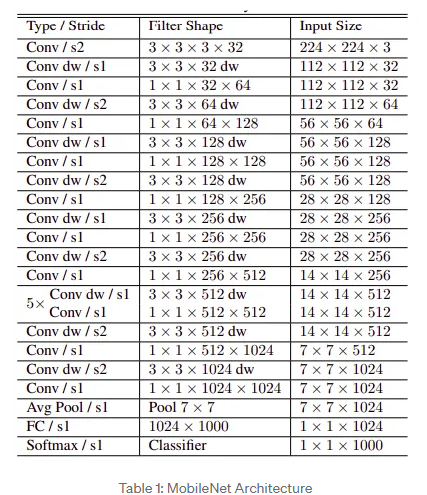

In [ ]:
class Depthwise_Conv(nn.Module):
    def __init__(self, in_channels, stride=1):
        super(Depthwise_Conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels   =   in_channels,
                out_channels  =   in_channels,
                kernel_size   =   3,
                stride        =   stride,
                padding       =   1,
                groups        =   in_channels # Conv on each channel separately, then stack the results
            ) ,
            nn.BatchNorm2d(in_channels),
            nn.ReLU()
        )

    def forward(self, input_image):
        x = self.conv(input_image)
        return x

class Pointwise_Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Pointwise_Conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels   =   in_channels,
                out_channels  =   out_channels,
                kernel_size   =   1,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, input_image):
        x = self.conv(input_image)
        return x

class Depthwise_Separable_Conv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Depthwise_Separable_Conv, self).__init__()
        self.dw = Depthwise_Conv(in_channels=in_channels, stride=stride)
        self.pw = Pointwise_Conv(in_channels=in_channels, out_channels=out_channels)

    def forward(self, input_image):
        x = self.pw(self.dw(input_image))
        return x

## MobileNetV1

In [ ]:
class MobileNetV1(nn.Module):
    def __init__(self, in_channels, num_classes=1000):
        super(MobileNetV1, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1), # Conv / s2
            nn.BatchNorm2d(32),
            nn.ReLU(),

            Depthwise_Separable_Conv(32, 64, stride=1), # Conv dw / s1
            Depthwise_Separable_Conv(64, 128, stride=2), # Conv dw / s2
            Depthwise_Separable_Conv(128, 128, stride=1), # Conv dw / s1
            Depthwise_Separable_Conv(128, 256, stride=2), # Conv dw / s2
            Depthwise_Separable_Conv(256, 256, stride=1), # Conv dw / s1
            Depthwise_Separable_Conv(256, 512, stride=2), # Conv dw / s2

            # 5x Conv dw / s1
            Depthwise_Separable_Conv(512, 512, stride=1),
            Depthwise_Separable_Conv(512, 512, stride=1),
            Depthwise_Separable_Conv(512, 512, stride=1),
            Depthwise_Separable_Conv(512, 512, stride=1),
            Depthwise_Separable_Conv(512, 512, stride=1),

            # 2x Conv dw / s2
            Depthwise_Separable_Conv(512, 1024, stride=2),
            Depthwise_Separable_Conv(1024, 1024, stride=2),

            # AvgPool
            nn.AdaptiveAvgPool2d(1), # AvgPool / s1
        )

        self.fc = nn.Linear(1024, num_classes) # FC / s1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        print(x.shape)
        x = x.view(x.size(0), 1024)
        print(x.shape)
        x = self.fc(x)
        x = self.softmax(x)
        return x

if __name__ == "__main__":
    model = MobileNetV1(in_channels=3, num_classes=10)
    batch_size = 64
    summary(model, (3, 224, 224), batch_size=batch_size, device='cpu')

torch.Size([2, 1024, 1, 1])
torch.Size([2, 1024])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [64, 32, 112, 112]             896
       BatchNorm2d-2         [64, 32, 112, 112]              64
              ReLU-3         [64, 32, 112, 112]               0
            Conv2d-4         [64, 32, 112, 112]             320
       BatchNorm2d-5         [64, 32, 112, 112]              64
              ReLU-6         [64, 32, 112, 112]               0
    Depthwise_Conv-7         [64, 32, 112, 112]               0
            Conv2d-8         [64, 64, 112, 112]           2,112
       BatchNorm2d-9         [64, 64, 112, 112]             128
             ReLU-10         [64, 64, 112, 112]               0
   Pointwise_Conv-11         [64, 64, 112, 112]               0
Depthwise_Separable_Conv-12         [64, 64, 112, 112]               0
           Conv2d-13           [64, 64, 56, 56

## MobileNetV2

1. Đây là mô hình dựa trên "Inverted residual structure"

Remind lại 1 chút về "Residual Structure", ta sẽ tranh thủ ôn lại kiến thức cũ về Residual Network (ResNet) và các kiến thức liên quan:

- *Epochs, Number of batchs, Iterations, Batch size là gì ?*

  - Epochs: Số lần đưa toàn bộ data vào mạng
  - Batch size: Số mẫu đưa vào mô hình trong mỗi iteration. Lí do phải chia data ra thành các batch là bởi vì tài nguyên phần cứng của chúng ta có hạn (RAM) nên ta không thể một lần load toàn bộ data vào RAM để train được
  - Number of batchs: Số lượng batch = Số lượng sample / Batch size
  - Iterations: Số vòng lặp để hoàn thành 1 epoch

  Ví dụ: "Với 12k5 ảnh, ta sẽ chạy ResNet18 trên 50 epochs, batch size 256" thì số iterations cho mỗi epochs sẽ là: 50. Batch size càng lớn đồng nghĩa với việc số lượng iteration sẽ nhỏ hơn nhưng thời gian trên cho 1 iteration lại tăng lên.

- *Batch Normalization*

ResNet là kiến trúc đầu tiên áp dụng Batch Normalization bên trong các Residual Block với mục đích giữ cho quá trình gradient descent ổn định, tránh tình trạng biến mất đạo hàm (vanishing gradient) khi kiến trúc sâu hơn.

Batch normalization được áp dụng trên mỗi mini-batch theo phân phối chuẩn tắc $N(0,1)$. Ví dụ, giả sử chúng ta có một batch $𝜷 = x_1, x_2, x_3, ..., x_m$. Các sample trong batch sẽ được rescale theo công thức sau:
$$μ = \dfrac{1}{m}\sum_{i=1}^m x_i $$

$$\sigma^2 = \dfrac{1}{m}\sum_{i=1}^m (x_i-\mu)^2 $$

Sample sẽ được normalize thành:

$$\hat{x}_i = \dfrac{x_i - \mu}{\sigma}$$

Để việc normalization trở nên tổng quát hơn, ta sẽ thường set mini-batch size cao (128 hoặc 256)

- *Skip Connection*

Tác giả của ResNet cho thấy kết quả thử nghiệm rằng, không phải lúc nào kiến trúc mạng sâu hơn cũng sẽ cho ra kết quả học tốt hơn.



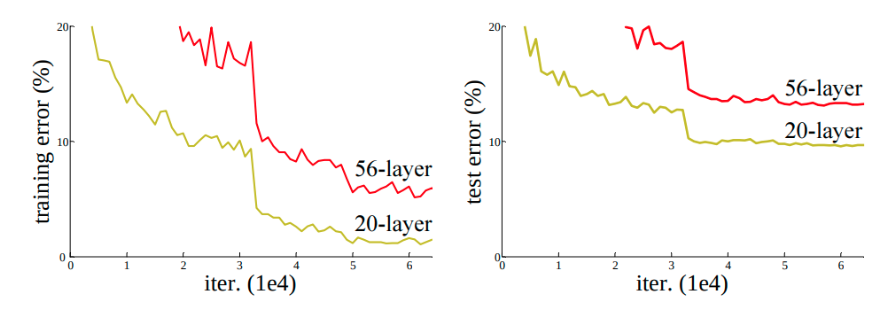

Hình dưới đây minh họa cho việc, đôi khi một cấu trúc mạnh mẽ hơn sẽ khiến cho việc tìm thấy điểm tối ưu (Hình ngôi sao) khó khăn hơn những cấu trúc đơn giản

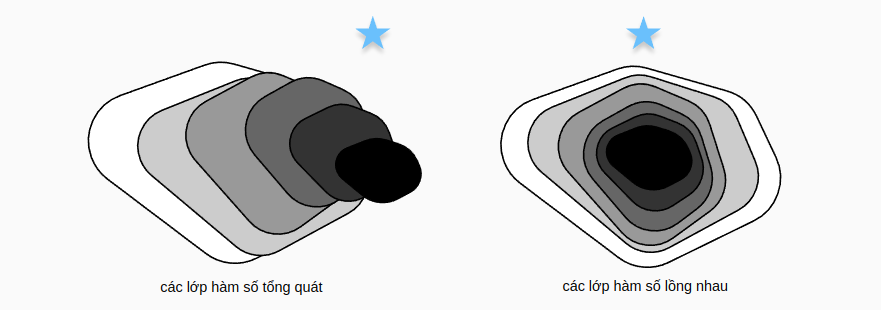

Chỉ khi các lớp hàm lớn hơn chứa các lớp nhỏ hơn thì mới đảm bảo rằng việc tăng thêm layers sẽ tăng khả năng biểu diễn của mạng.

Do đó giải pháp đưa ra bởi tác giả là thêm 1 lớp identify mapping layer (ánh xạ nhận dạng) để sao chép layer đã học nông sang các layer sâu hơn.

Lúc này, identify mapping layer được cộng trực tiếp vào input block cho ra khối output với cùng shape

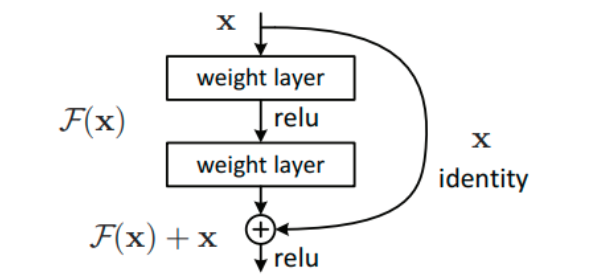

Khác biệt lớn nhất giữa "Inverted Residual Block" trong MobileNetV2 và "Residual Block" trong ResNet đó chính là số lượng channel ở input và output block.

Nếu như số lượng channel ở input và output block lớn hơn so với các layer trung gian thì đối với "Inverted Residual Block", điều này là ngược lại. Tác giả cho răng các layer trung gian trong 1 block sẽ làm nhiệm vụ biến đổi non-linear nến cần "dày" hơn để tạo ra nhiều phép biến đổi hơn.

Trong một block inverted residual block, ta sẽ tiến hành depth-wise separable convolution để giảm thiểu số lượng tham số của mô hình

2. Loại bỏ hàm Non-Linear tại layer input và output và thay bằng các phép chiếu tuyến tính

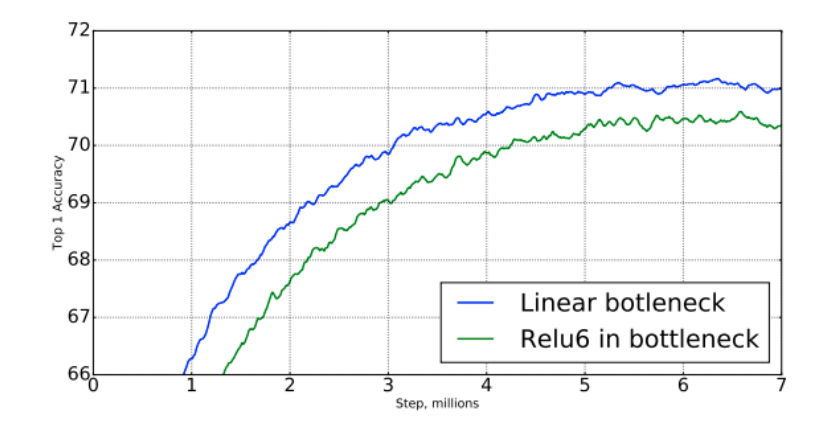

Một trong những thực nghiệm được tác giả ghi nhận đó là việc sử dụng các biến đổi phi tuyến (như biến đổi qua ReLu hoặc sigmoid) tại input và output của các residual block sẽ làm cho thông tin bị mất mát.

Chính vì thế trong kiến trúc của residual block tác giả đã loại bỏ hàm phi tuyến tại layer input và output và thay bằng các phép chiếu tuyến tính.

In [ ]:
import torch
from torch import nn

class InvertedLinearResidualBlock(nn.Module):
    def __init__(self, expand=64, squeeze=16):
        '''
        expand: số lượng channel của layer trung gian
        squeeze: số lượng channel của layer bottleneck input và output
        '''
        super(InvertedLinearResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            # Depthwise Convolution
            nn.Conv2d(squeeze, expand, kernel_size=3, stride=1, padding=1, groups=squeeze, bias=False),
            nn.ReLU6(inplace=True),
            # Pointwise Convolution + Linear projection
            nn.Conv2d(expand, squeeze, kernel_size=1, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        return x + self.conv(x)

x = torch.randn(10, 16, 64, 64) # Batch_size, C, W, H
y = InvertedLinearResidualBlock(expand=64, squeeze=16)(x)
y.size()

torch.Size([10, 16, 64, 64])

## MobileNetV3

Nếu như 2 keywords chính của MobileNetV2 là "Inverted Residual Block" và "Layer BottleNeck" thì keyword của MobileNetV3 là "Squeeze and Excitation Block"

---

